In [6]:
import time
import itertools
import sympy as sp
import numpy as np
from sympy.vector import dot
from sympy.physics.quantum import Commutator, Operator
from sympy.interactive import printing
from sympy.vector import CoordSys3D
from random import shuffle
import pandas as pd
import editdistance
import jellyfish
import matplotlib.pyplot as plt
printing.init_printing(use_latex = True)


Pi_RA, M, w_0, h_RA, p, m, w, x, H, Pi_RB, h_RB, h_RS, Q, h, zhat = sp.symbols('\\Pi_{\\mathbf{R_A}}, M, \\omega_0, h_{\\mathbf{R_A}}, p, m, \\omega, x, H, \\Pi_{\\mathbf{R_B}}, h_{\\mathbf{R_B}}, h_{\\mathbf{R_S}}, Q, \\mathbf{h} \\hat{\\mathbf{z}}')
V, p1, p2, nhat, r1, r2, eps0, hbar = sp.symbols('V \\mathbf{p} \\mathbf{p^\prime} \\hat{\\mathbf{n}} \\mathbf{r} \\mathbf{r^\prime} \epsilon_0 \\hbar')
N = CoordSys3D('N')
a = sp.Symbol('a', real = True, positive = True)

R = [((H, p**2/(2*m) + w**2*m*x**2/2), ('hamiltonian', H), ('momentum', p), ('mass', m), ('angular frequency', w), ('displacement', x)), 
    ((sp.Symbol('\\mathbf{p}'),-Q*h*nhat), ('dipole moment', sp.Symbol('\\mathbf{p}')), ('charge', Q), ('displacement', h), ('unit vector', nhat)),
    ((V, (dot(p1, p2) - 3*dot(p1,nhat)*dot(p2,nhat))/(4*sp.pi*eps0*sp.Abs(r1 - r2)**3)), ('potential energy', V), ('dipole moment', p1, p2), ('unit vector', nhat), ('displacement', r1, r2)),
    ((nhat, (r1 - r2)/sp.Abs(r1 - r2)), ('unit vector', nhat), ('displacement', r1, r2)),
    ((Operator('a'), sp.sqrt(m*w/(2*hbar))*x + sp.I*sp.sqrt(1/(2*hbar*m*w))*p), ('annihilation operator', Operator('a')), ('mass', m), ('angular frequency', w), ('displacement', x), ('momentum', p)),
    ((Operator('a^{\\dagger}'), sp.sqrt(m*w/(2*hbar))*x - sp.I*sp.sqrt(1/(2*hbar*m*w))*p), ('creation operator', Operator('a^{\\dagger}')), ('mass', m), ('angular frequency', w), ('displacement', x), ('momentum', p)),
    ((Commutator(Operator('a'), Operator('a^{\\dagger}')), sp.Number(1)), ('annihilation operator', Operator('a')), ('creation operator', Operator('a^{\\dagger}'))),
    ((Operator('N^{\\dagger}'), Operator('a')*Operator('a^{\\dagger}')), ('number operator', (Operator('N^{\\dagger}')), ('annihilation operator', Operator('a')), ('creation operator', Operator('a^{\\dagger}')))), 
    ((Operator('a_{\\mathbf{R}}'), (1/sp.sqrt(sp.Symbol('N')))*sp.Symbol('\\sum_{\\mathbf{q}}')*Operator('a_{\\mathbf{q}}')*sp.exp(sp.I*dot(sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{R}')))), ('annihilation operator', Operator('a_{\\mathbf{R}}'), Operator('a_{\\mathbf{q}}')), ('displacement', sp.Symbol('\\mathbf{R}')), ('wavevector', sp.Symbol('\\mathbf{q}'))), 
    ((Operator('a_{\\mathbf{R}}^{\\dagger}'), (1/sp.sqrt(sp.Symbol('N')))*sp.Symbol('\\sum_{\\mathbf{q}}')*Operator('a_{\\mathbf{q}}^{\\dagger}')*sp.exp(-sp.I*dot(sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{R}')))), ('creation operator', Operator('a_{\\mathbf{R}}^{\\dagger}'), Operator('a_{\\mathbf{q}}^{\\dagger}')), ('displacement', sp.Symbol('\\mathbf{R}')), ('wavevector', sp.Symbol('\\mathbf{q}'))), 
    ((Operator('\\delta_{\\mathbf{q},\\mathbf{q^\\prime}}'), sp.Symbol('\\sum_{\\mathbf{R}}')*sp.exp(sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q}'),sp.Symbol('\\mathbf{R}')))*sp.exp(-sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q^\\prime}'),sp.Symbol('\\mathbf{R}')))/sp.Symbol('N')), ('number', sp.Symbol('N')), ('dirac delta', Operator('\\delta_{\\mathbf{q}\\mathbf{q^\\prime}}')), ('wavevector', sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{q^\\prime}')), ('displacement', sp.Symbol('\\mathbf{R}')), ('summation sign', sp.Symbol('\\sum_{\\mathbf{R}}'))), 
    ((Operator('\\delta_{\\mathbf{q},\\mathbf{q^\\prime}}'), sp.Symbol('\\sum_{\\mathbf{R}}')*sp.exp(-sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q}'),sp.Symbol('\\mathbf{R}')))*sp.exp(sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q^\\prime}'),sp.Symbol('\\mathbf{R}')))/sp.Symbol('N')), ('number', sp.Symbol('N')), ('dirac delta', Operator('\\delta_{\\mathbf{q}\\mathbf{q^\\prime}}')), ('wavevector', sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{q^\\prime}')), ('displacement', sp.Symbol('\\mathbf{R}')), ('summation sign', sp.Symbol('\\sum_{\\mathbf{R}}'))),
    ((Operator('\\delta_{-\\mathbf{q},\\mathbf{q^\\prime}}'), sp.Symbol('\\sum_{\\mathbf{R}}')*sp.exp(sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q}'),sp.Symbol('\\mathbf{R}')))*sp.exp(sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q^\\prime}'),sp.Symbol('\\mathbf{R}')))/sp.Symbol('N')), ('number', sp.Symbol('N')), ('dirac delta', Operator('\\delta_{\\mathbf{q}\\mathbf{q^\\prime}}')), ('wavevector', sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{q^\\prime}')), ('displacement', sp.Symbol('\\mathbf{R}')), ('summation sign', sp.Symbol('\\sum_{\\mathbf{R}}'))),
    ((Operator('\\delta_{-\\mathbf{q},\\mathbf{q^\\prime}}'), sp.Symbol('\\sum_{\\mathbf{R}}')*sp.exp(-sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q}'),sp.Symbol('\\mathbf{R}')))*sp.exp(-sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q^\\prime}'),sp.Symbol('\\mathbf{R}')))/sp.Symbol('N')), ('number', sp.Symbol('N')), ('dirac delta', Operator('\\delta_{\\mathbf{q}\\mathbf{q^\\prime}}')), ('wavevector', sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{q^\\prime}')), ('displacement', sp.Symbol('\\mathbf{R}')), ('summation sign', sp.Symbol('\\sum_{\\mathbf{R}}')))]

S_sys = (('displacement', h_RA, h_RB, h_RS, sp.Symbol('\\mathbf{R_A}'), sp.Symbol('\\mathbf{R_B}'), sp.Symbol('\\mathbf{R_S}')), ('momentum', Pi_RA, Pi_RB), ('mass', M), ('angular frequency', w_0),
        ('dipole moment', sp.Symbol('\\mathbf{p_{R_A}}'), sp.Symbol('\\mathbf{p_{R_B}}'), sp.Symbol('\\mathbf{p_{R_S}}')), ('unit vector', nhat, sp.Symbol('\\hat{\\mathbf{z}}')),
        ('annihilation operator', Operator('a_{\\mathbf{R_A}}'), Operator('b_{\\mathbf{R_B}}'), Operator('a_{\\mathbf{q}}'), Operator('b_{\\mathbf{q}}')),
        ('creation operator', Operator('a_{\\mathbf{R_A}}^{\\dagger}'), Operator('b_{\\mathbf{R_B}}^{\\dagger}'), Operator('a_{\\mathbf{q}}^{\\dagger}'), Operator('b_{\\mathbf{q}}^{\\dagger}')), 
        ('number operator', Operator('N^{\\dagger}')), ('number', sp.Symbol('N')), ('summation sign', sp.Symbol('\\sum_{j=1}^3'), sp.Symbol('\\sum_{\\mathbf{R_A}}'), sp.Symbol('\\sum_{\\mathbf{R_B}}'), sp.Symbol('\\sum_{\\mathbf{R_S}}'), sp.Symbol('\\sum_{\\mathbf{q}}'), sp.Symbol('{\\sum^\\prime}_{l = -\\infty}^{\\infty}')))

R_eq = [i[0] for i in R]

pairs = []
for i in R:
    for j in i[1:]:
        for k in S_sys:
            if j[0] == k[0]:
                for l in j[1:]:
                    for n in k[1:]:
                        pair = (l, n)
                        pairs.append(pair) if pair not in pairs else 0             
R_eq_syms = []
for i,j in R_eq:
    R_eq_syms.append(list(i.atoms(sp.Symbol)) + list(j.atoms(sp.Symbol)))
R_eq_pairs = [[] for i in R_eq]
for i,j in pairs:
    for k in range(len(R_eq_syms)):
        for l in R_eq_syms[k]:
            if str(i) == str(l):
                R_eq_pairs[k].append((i,j))

S_match = []
for k in R_eq_pairs:
    tree = {}
    for i,j in k:
        if i not in tree:
            tree[i] = []
        tree[i].append((i,j))
    S_match.append(list(itertools.product(*tree.values())))

def f_match(eq, s):
    LHS, RHS = eq[0], eq[1] 
    for pair in s:
        LHS = LHS.subs(pair[0], pair[1])
        RHS = RHS.subs(pair[0], pair[1])
    return (LHS, RHS)

R_M = []
for i in range(len(R_eq)):
    for s in S_match[i]:
        R_M.append(f_match(R_eq[i], s)) if f_match(R_eq[i], s) not in R_M else 0
for i, j in R_M:
    R_M.remove((i, j)) if j == sp.nan else 0

R_sys = [(sp.Symbol('\\mathbf{R_A}'), sp.Symbol('\\mathbf{R_B}') + sp.Symbol('\\mathbf{e_j}')), (sp.Symbol('\\mathbf{e_j}'), sp.sqrt(3)*a/2*N.j + a/2*N.i), (sp.Symbol('\\hat{\\mathbf{z}}'), N.k), 
        (sp.Symbol('\\mathbf{e_1}'), sp.sqrt(3)*a/2*N.i + a/2*N.j), (sp.Symbol('\\mathbf{e_2}'), -sp.sqrt(3)*a/2*N.i + a/2*N.j), (sp.Symbol('\\mathbf{e_3}'), -a*N.j), 
        (sp.Symbol('\\mathbf{R_A}'), sp.Symbol('\\mathbf{R_B}') + sp.Symbol('\\mathbf{e_j}') + sp.Symbol('l')*sp.Symbol('L')*sp.Symbol('\\hat{\\mathbf{z}}')), 
        (sp.Symbol('\\mathbf{R_A}'), sp.Symbol('\\mathbf{R_A}') + sp.Symbol('l')*sp.Symbol('L')*sp.Symbol('\\hat{\\mathbf{z}}')), 
        (sp.Symbol('\\mathbf{R_B}'), sp.Symbol('\\mathbf{R_B}') + sp.Symbol('l')*sp.Symbol('L')*sp.Symbol('\\hat{\\mathbf{z}}')),
        (8*sp.Symbol('\\Omega'), sp.Symbol('Q')**2/(sp.pi*eps0*sp.Symbol('M')*w_0*a**3)), 
        (sp.Symbol('\\mathcal{S}')/4, sp.Symbol('\\sum_{l = 1}^{\\infty}')*sp.Symbol('a')**3*(sp.Symbol('l', commutative = False)**2*sp.Symbol('L')**2)**(-sp.Number(3)/sp.Number(2))),
        (-sp.Symbol('\\mathcal{I}')/2, sp.Symbol('\\sum_{l = 1}^{\\infty}')*sp.Symbol('a')**3*(sp.Symbol('a')**2 + sp.Symbol('l', commutative = False)**2*sp.Symbol('L')**2)**(-sp.Number(5)/sp.Number(2))*(sp.Symbol('a')**2 - 2*sp.Symbol('l', commutative = False)**2*sp.Symbol('L')**2)), 
        (sp.Symbol('f_{\\mathbf{q}}'), sp.Symbol('\\sum_{j=1}^3')*sp.exp(sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{e_j}')))),
        (sp.Symbol('f_{\\mathbf{q}}^*'), sp.Symbol('\\sum_{j=1}^3')*sp.exp(-sp.I*sp.vector.dot(sp.Symbol('\\mathbf{q}'), sp.Symbol('\\mathbf{e_j}')))),
        (sp.Symbol('\\tilde{\\Omega}'), sp.Symbol('\\Omega')*(1-sp.Symbol('\\mathcal{I}'))), (sp.Symbol('\\tilde{\\omega}_0'), w_0 - sp.Symbol('\\Omega')*sp.Symbol('\\mathcal{S}'))]

R_M = R_M + R_sys

def find_atoms(state):
    operators = list(state[0].atoms(Operator)) + list(state[1].atoms(Operator))
    operator_strings = [str(i) for i in operators]
    syms = list(state[0].atoms(sp.Symbol)) + list(state[1].atoms(sp.Symbol))
    atoms = [i for i in syms if str(i) not in operator_strings]
    atoms += operators
    return atoms

def noncommutise(state, _):
    syms = [i for i in state[1].atoms(sp.Symbol) if '\\sum' not in str(i)] + [i for i in state[0].atoms(sp.Symbol) if '\\sum' not in str(i)] 
    new_syms = [sp.Symbol(str(i), commutative = False) for i in syms]
    RHS = state[1]
    LHS = state[0]
    for i in range(len(syms)):
        LHS = LHS.subs(syms[i], new_syms[i])
        RHS = RHS.subs(syms[i], new_syms[i])
    return indexer(LHS), RHS

def commutise(state, _):
    syms = [i for i in state[1].atoms(sp.Symbol) if '\\sum' not in str(i)] + [i for i in state[0].atoms(sp.Symbol) if '\\sum' not in str(i)]
    new_syms = [sp.Symbol(str(i)) for i in syms]
    RHS = state[1]
    LHS = state[0]
    for i in range(len(syms)):
        RHS = RHS.subs(syms[i], new_syms[i])
        LHS = LHS.subs(syms[i], new_syms[i])
    return indexer(LHS), RHS

def indexer(LHS):
    if len(list(LHS.atoms())) < 2:
        state_history_LHS = [str(i[0]) for i in state_history]
        if str(LHS) not in state_history_LHS:
            return LHS
        else:
            while True:
                if '\\dagger' not in str(LHS):
                    if len(str(LHS).split('^{(')) == 1:
                        if type(LHS) == sp.physics.quantum.Operator:
                            LHS = Operator(str(LHS) + '^{(1)}')
                        else:
                            LHS = sp.Symbol(str(LHS) + '^{(1)}')
                    else:
                        index = str(LHS).split('^{(')[1].split(')}')[0]
                        new_index = str(int(str(LHS).split('^{(')[1].split(')}')[0])+1)
                        if type(LHS) == sp.physics.quantum.Operator:
                            LHS = Operator(str(LHS).replace(index, new_index)) 
                        else:
                            LHS = sp.Symbol(str(LHS).replace(index, new_index))
                else:
                    counter = 0
                    if len(str(LHS).split('\\dagger (')) == 1:
                        LHS = Operator(str(LHS).replace('\\dagger', '\\dagger (1)'))
                    else:
                        index = str(LHS).split('(')[-1:][0].split(')}')[0]
                        new_index = str(int(index) + 1)
                        LHS = Operator(str(LHS).replace(index, new_index))
                if str(LHS) not in state_history_LHS:
                    break
            return LHS
    else:
        return LHS

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def evaluate_abs(state, _):
    try:
        #state = commutise(state, None)
        dp_vectors = []
        for i,j in R_M:
                if type(j) == sp.vector.VectorMul or type(j) == sp.vector.VectorAdd or type(j) == sp.vector.BaseVector:
                    dp_vectors.append((i,j))
        Abs = list(state[1].atoms(sp.Abs))
        args = [i.args[0] for i in Abs]
        new_Abs = []
        for arg in args:
            if type(arg) == sp.Add:
                sum_parts = arg.args
                new_sum_parts = []
                sum_parts_syms = [list(i.atoms(sp.Symbol)) for i in sum_parts]
                for i in range(len(sum_parts_syms)):
                    for j in sum_parts_syms[i]:
                        for k in dp_vectors:
                            if j == k[0]:
                                new_sum_parts.append(sum_parts[i].subs(k[0], 1)*k[1])
                new_arg = new_sum_parts[0]
                for i in range(1, len(sum_parts)):
                    new_arg += new_sum_parts[i]
                new_Abs.append(sp.sqrt(dot(new_arg, new_arg)))
            else:
                arg_syms = list(arg.atoms(sp.Symbol))
                for i in arg_syms:
                    for j in dp_vectors:
                        if i == j[0]:
                            new_arg = arg.subs(j[0], 1)*j[1]
                            new_Abs.append(sp.sqrt(dot(new_arg, new_arg)))
        output = state[1]
        for i in range(len(Abs)):
            output = output.subs(Abs[i], new_Abs[i])
        return indexer(state[0]), output
    except:
        return state

def evaluate_dot(state, _):
    try:
        dp_vectors = []
        for i,j in R_M:
                if type(j) == sp.vector.VectorMul or type(j) == sp.vector.VectorAdd or type(j) == sp.vector.BaseVector:
                    dp_vectors.append((i,j))
        dots = list(state[1].atoms(sp.vector.Dot))
        args = [i.args for i in dots]
        new_dots = []
        for arg in args:
            LHS, RHS = arg[0], arg[1]
            for side in [LHS, RHS]:
                side_args = side.args
                side_args_syms = [list(i.atoms()) for i in side_args]
                if type(side) == sp.Add:
                    side = sp.expand(side)
                    subable_syms = []
                    for syms in side_args_syms:
                        for sym in syms:
                            for vec in dp_vectors:
                                if sym == vec[0]:
                                    subable_syms.append(vec) if vec not in subable_syms else 0
                    new_side_args = []
                    for side_arg in side_args:
                        for subable_sym in subable_syms:
                            new_side_args.append(side_arg.subs(subable_sym[0], 1)*subable_sym[1]) if side_arg.subs(subable_sym[0], 1) != side_arg else 0
                    new_side = new_side_args[0]
                    for i in range(1, len(new_side_args)):
                        new_side += new_side_args[i]
                    if side == RHS:
                        new_RHS = new_side
                    else:
                        new_LHS = new_side
                else:
                    subable_syms = []
                    for side_args_sym_list in side_args_syms:
                        for side_args_sym in side_args_sym_list:
                            for vec in dp_vectors:
                                if vec[0] == side_args_sym:
                                    subable_syms.append(vec)
                    new_side = side
                    for subable_sym in subable_syms:
                        new_side = new_side.subs(subable_sym[0], 1)*subable_sym[1]
                    if side == RHS:
                        new_RHS = new_side
                    else:
                        new_LHS = new_side
            new_dot = sp.vector.dot(new_LHS, new_RHS)
            new_dots.append(new_dot)
        out = state[1]
        for i in range(len(dots)):
            out = out.subs(dots[i], new_dots[i])
        return indexer(state[0]), out
    except:
        return state

def expand_sum(state, _):
    try:
        #state = commutise(state, None)
        "Expands a sum if the index of the summation sign corresponds to a subscript in the summand, else returns state"
        sum_sign = []
        for i in [i for i in state[1].atoms(sp.Symbol) if '\\sum' in str(i)]:
            if len(str(i).split('^')) > 1 and '\\infty' not in str(i):
                sum_sign.append(i) if len(sum_sign) < 1 else 0
        if sum_sign == []:
            return state
        else:
            sum_sign = sum_sign[0]
            start = int(str(sum_sign).split('_')[1].split('^')[0].split('=')[1].split('}')[0])
            stop = int(str(sum_sign).split('_')[1].split('^')[1]) + 1
            index = str(sum_sign).split('_')[1].split('^')[0].split('=')[0].split('{')[1]
            sum_parts = [[i] for i in range(start, stop)]
            out = 0
            for i in sum_parts:
                i.append(state[1]/sum_sign)
                i.append([k for k in [j for j in i[1].atoms(sp.Symbol) if index in str(j)] if '\\sum' not in str(k)])
                i.append([])
                last = i[1]
                for j in range(len(i[2])):
                    i[3].append(sp.Symbol(str(i[2][j]).replace(index, str(i[0]))))
                    last = last.subs(i[2][j], i[3][j])
                i.append(last)
                out += i[-1:][0]
            return (indexer(state[0]), out)
    except:
        return state

def subs_subscript_LHS_for_RHS(state, NSA):
    try:
        syms = []
        l = list(state[1].atoms(sp.Symbol)) + list(state[0].atoms(sp.Symbol))
        for sym in l:
            s = str(sym).split('_')
            if len(s) > 1:
                subscript = s[1]
                for j in range(2, len(s)):
                    subscript += '_' + s[j]
                    if str(NSA[0]) in subscript:
                        syms.append(sym)
        new_syms = []
        for i in syms:
            new_sym = sp.Symbol(str(i).replace(str(NSA[0]), str(NSA[1])).replace('*', ''))
            new_syms.append(new_sym)
        LHS_out, RHS_out = state[0], state[1]
        for i in range(len(syms)):
            LHS_out = LHS_out.subs(syms[i], new_syms[i])
            RHS_out = RHS_out.subs(syms[i], new_syms[i])
        return indexer(LHS_out), RHS_out
    except:
        return state

def recast_as_summation_over_index_in_summand(state, _):
    #state = commutise(state, None)
    "If the state can be represented as a sum over a single subscript, then this represents the expanded state as a sum acting on a compact summand"
    try:
        index = 'j'
        alphabet = ['A', 'B', 'C', 'D', 'E']
        numbers = range(-20, 20)
        l, nl = [], []
        syms = [j for j in [i for i in state[1].atoms(sp.Symbol) if len(str(i).split('_')) > 1] if 'sum' not in str(j)]
        repeats = [0 for i in syms]
        for i in range(len(syms)):
            for j in range(len(syms)):
                if str(syms[i]).split('_')[0] == str(syms[j]).split('_')[0]:
                    repeats[j] += 1
        for i in range(len(repeats)):
            if repeats[i] == 1:
                syms.remove(syms[i])
        for i in numbers:
            for j in syms:
                if str(i) in str(j):
                    l.append(j)
        if len(l) == 0:
            index = 'S'
            if len([i for i in state[1].args if type(i) == sp.Add]) == 0:
                index = 'S'
                args = state[1].args
                args_syms = []
                for i in range(len(args)):
                    for letter in alphabet:
                        syms = [j for j in args[i].atoms(sp.Symbol) if '_%s'%(letter) in str(j)]
                        args_syms.append(syms) if syms != [] else 0
                letters_used = []
                new_args_syms = [i.copy() for i in args_syms] # MEGA IMPORTANT
                for i in range(len(args_syms)):
                    for j in range(len(args_syms[i])):
                        for letter in alphabet:
                            if '_%s'%(letter) in str(args_syms[i][j]):
                                letters_used.append(letter) if letter not in letters_used else 0
                                new_args_syms[i][j] = sp.Symbol(str(new_args_syms[i][j]).replace('_%s'%(letter), '_%s'%(index)))
                if len(args) == len(new_args_syms) == len(letters_used):
                    term = args[0]
                    for i in range(len(args_syms[0])):
                        term = term.subs(args_syms[0][i], new_args_syms[0][i])
                    sum_sign = '\\sum_{%s = '%(index)
                    for i in range(len(letters_used)):
                        sum_sign = sum_sign + letters_used[i] + ',' if i != (len(letters_used) - 1) else sum_sign + letters_used[i] + '}'
                    out = sp.Symbol(sum_sign)*term
                    return indexer(state[0]), out
            else:
                terms = [j for j in [i for i in state[1].args if type(i) == sp.Add][0].factor().args if type(j) == sp.Add]
                terms_args = [i.args for i in terms]
                terms_args_syms = [[] for i in terms_args]
                for i in range(len(terms_args_syms)):
                    for j in range(len(terms_args[i])):
                        terms_args_syms[i].append(list(terms_args[i][j].atoms(sp.Symbol)))
                letters_used = []
                new_terms_args_syms = [i.copy() for i in terms_args_syms] 
                for i in range(len(terms_args_syms)):
                    for j in range(len(terms_args_syms[i])):
                        for k in range(len(terms_args_syms[i][j])):
                            for letter in alphabet:
                                if '_%s'%(letter) in str(terms_args_syms[i][j][k]):
                                    letters_used.append(letter) if letter not in letters_used else 0
                                    new_terms_args_syms[i][j][k] = sp.Symbol(str(terms_args_syms[i][j][k]).replace('_%s'%(letter), '_%s'%(index)))
                terms_args_syms = [[] for i in terms_args]
                for i in range(len(terms_args_syms)):
                    for j in range(len(terms_args[i])):
                        terms_args_syms[i].append(list(terms_args[i][j].atoms(sp.Symbol)))
                new_terms_args = [[] for i in terms_args]
                for i in range(len(terms_args)):
                    for j in range(len(terms_args_syms[i])):
                        new_terms_arg = terms_args[i][j]
                        for k in range(len(terms_args_syms[i][j])):
                            new_terms_arg = new_terms_arg.subs(terms_args_syms[i][j][k], new_terms_args_syms[i][j][k])
                        new_terms_args[i].append(new_terms_arg)
                if new_terms_args == terms_args == letters_used == []:
                    return state
                else:
                    if len(new_terms_args[0]) == len(terms_args[0]) == len(letters_used):
                        sum_sign = '\\sum_{%s = '%(index)
                        for i in range(len(letters_used)):
                            sum_sign = sum_sign + letters_used[i] + ',' if i != (len(letters_used) - 1) else sum_sign + letters_used[i] + '}'
                        out = sp.Symbol(sum_sign)*new_terms_args[0][0]
                        new_state = ((indexer(state[0]), state[1].simplify().subs(terms[0], out)))
                        return noncommutise(new_state, None)
        elif len(l) > 0:            
            nums_in_sum = []
            for i in l:
                for j in numbers:
                    if str(j) in str(i):
                        nl.append(sp.Symbol(str(i).replace(str(j), 'j')))
                        nums_in_sum.append(j) if j not in nums_in_sum else 0
            out = state[1]
            for i in range(len(l)):
                out = out.subs(l[i], nl[i])
            return indexer(state[0]), sp.Symbol('\\sum_{%s=%d}^%d' % (index, min(nums_in_sum), max(nums_in_sum)))*sp.simplify(out/len(nums_in_sum)) # I HAVE REDUCED the j = 1 to j=1 in THIS LINE
        else:
            return state
    except:
        return state

def solve_equation_for_NSA(state, NSA):
    "Takes first answer as solution"
    try:
        if str(NSA) not in [str(i) for i in state[1].atoms()] + [str(i) for i in state[0].atoms()] or len(split(str(state))) > 200:
            return state
        else:
            eq = sp.Eq(state[0], state[1])
            out = sp.solve(eq, NSA)
            if out == []:
                "account for operators both side of equation (they are both operators, keep it that way"
                operators = []
                for sym_type in S_sys:
                    if sym_type[0] == 'creation operator' or sym_type[0] == 'annihilation operator':
                        for i in sym_type[1:]:
                            operators.append(i)
                LHS, RHS = state
                new_syms = list(LHS.atoms(sp.Symbol)) + list(RHS.atoms(sp.Symbol))
                syms = []
                for new_sym in new_syms:
                    if Operator(str(new_sym)) in set(operators):
                        syms.append(Operator(str(new_sym)))
                    else:
                        syms.append(new_sym)
                new_LHS, new_RHS = LHS, RHS
                for i in range(len(syms)):
                    new_LHS = new_LHS.subs(syms[i], new_syms[i])
                    new_RHS = new_RHS.subs(syms[i], new_syms[i])
                eq = sp.Eq(new_LHS, new_RHS)
                out = sp.solve(eq, NSA)
                if out == []:
                    return state
                else:
                    new_out = out[0]
                    for i in range(len(syms)):
                        new_out = new_out.subs(new_syms[i], syms[i])
                    return indexer(NSA), new_out
            else:
                return indexer(NSA), out[0]
    except:
        return state

def take_latex_arg(NSA):
    s = str(NSA).split('\\')
    if s[0] == '':
        t = s[1].split('{')[0]
        if len(t.split('_')) == 1 and len(t.split()) == 1:
            splitter = ('\\'+t+'{')
            if len(str(NSA).split(splitter)) <= 1:
                return str(NSA)
            else:
                almost_arg = str(NSA).split(splitter)[1]
                out = almost_arg.split('}')[0]
                if len(out.split('}')) == 1 and len(out.split('{')) > 1:
                    return out + '}'
                else:
                    return out
        else:
            return str(NSA)
    else:
        return str(NSA)

def generate_new_state_if_substitution_of_NSA_for_symbol_in_denominator_causes_divergence(state, NSA):
    try:
        pairs = []
        syms = list(state[1].atoms(sp.Symbol))
        for i in syms:
            for j in syms:
                if i != j:
                    pairs.append((i, j))
        pole_pairs = []
        poles = []
        for pair in pairs:
            if str(sp.oo) in str(state[1].subs(pair[0], pair[1])):
                pole_pairs.append(pair)
        for pole_pair in pole_pairs:
            for pole in pole_pair:
                if pole != NSA:
                    special_pair = (pole, sp.Symbol(str(NSA).replace(take_latex_arg(NSA), take_latex_arg(NSA) + '^\\prime')))
                    poles.append(special_pair) if special_pair not in poles else 0
        if len(poles) != 0:
            new_syms = []
            for i in syms:
                new_syms.append(sp.Symbol(str(i).replace(take_latex_arg(poles[0][0]), take_latex_arg(poles[0][1])))) # take_latex_arg was previously "str"
            out = state[1]
            for i in range(len(syms)):
                out = out.subs(syms[i], new_syms[i])
            return indexer(state[0]), out
        else:
            return state
    except:
        return state

def prime_all_NSA_in_state(state, NSA):
    try:
        operators = []
        for sym_type in S_sys:
            if sym_type[0] == 'creation operator' or sym_type[0] == 'annihilation operator':
                for i in sym_type[1:]:
                    operators.append(i)
        syms = [i for i in state[1].atoms(sp.Symbol) if str(NSA) in str(i)] + [i for i in state[0].atoms(sp.Symbol) if str(NSA) in str(i)]
        l = list(state[1].atoms(sp.Symbol)) + list(state[0].atoms(sp.Symbol))
        for i in l:
            if take_latex_arg(NSA) in take_latex_arg(i):
                syms.append(i) if i not in syms else 0
        new_syms = []
        str_new_syms = []
        for sym in syms:
            new_sym = sp.Symbol(str(sym).replace(take_latex_arg(NSA), take_latex_arg(NSA) + '^\\prime'))
            s = str(new_sym).split('^')
            if '{\\dagger}' in s:
                new_sym = Operator(s[0] + '^' + s[1] + '^{\\dagger}')
                new_syms.append(new_sym)
            elif len(s) > 1:
                operator_strings = [str(i) for i in operators]
                if str(sym) in operator_strings:
                    new_sym = Operator(s[0] + '^' + s[1])
                    new_syms.append(new_sym)
                else:
                    new_sym = sp.Symbol(s[0] + '^' + s[1])
                    new_syms.append(new_sym)
        operator_strings = [str(i) for i in operators]
        for i in range(len(syms)):
            if str(syms[i]) in operator_strings:
                new_syms[i] = Operator(str(new_syms[i]))
        out_LHS, out_RHS = state[0], state[1]
        for i in range(len(syms)):
            out_LHS = out_LHS.subs(syms[i], new_syms[i])
            out_RHS = out_RHS.subs(syms[i], new_syms[i])
        return indexer(out_LHS), out_RHS
    except:
        return state

def unprime_NSA_in_state(state, NSA):
    try:
        syms = []
        for i in state[1].atoms(sp.Symbol):
            if 'prime' in str(i) or take_latex_arg(NSA) in str(i):
                syms.append(i)
        if len(syms) == 0:
            return state
        new_syms = []
        for sym in syms:
            new_sym = sp.Symbol(str(sym).replace('^\\prime', ''))
            new_syms.append(new_sym)
            out = state[1]
        for i in range(len(syms)):
            out = out.subs(syms[i], new_syms[i])
        return indexer(state[0]), out
    except:
        return state

def halve_potential_between_real_and_image_dipoles(state, _):
    return indexer(state[0]), state[1]/2

def remove_index(state, _):
    try:
        if len(str(state[0]).split('^')) > 1:
            s = str(state[0]).split('^')[0]
            if '\\dagger' not in str(state[0]):
                if type(state[0]) == sp.physics.quantum.Operator:
                    return Operator(s), state[1]
                else:
                    return sp.Symbol(s), state[1]
            else:
                for i in range(len(state_history)):
                    s = str(state[0]).replace(' (%d)'%(i), '')
                    if s != str(state[0]):
                        return Operator(s), state[1]
        else:
            return state
    except:
        return state

def ignore_zero_point_energy(state, _):
    try:
        RHS = state[1].expand()
        operators = []
        for i in S_sys:
            if 'operator' in i[0]:
                for j in i[1:]:
                    operators.append(j)
        args = [i.copy() for i in RHS.args]
        zero_points = []
        for arg in args:
            for operator in operators:
                if str(operator) in [str(i) for i in arg.atoms(sp.Symbol)]:
                    args.remove(arg) if arg in args else 0
        new_RHS = RHS
        for arg in args:
            new_RHS = new_RHS.subs(arg, 0)
        return indexer(state[0]), new_RHS
    except:
        return state

def multiply_top_and_bottom_by_NSA_cubed(state, NSA):
    out = ((sp.Symbol(str(NSA), commutative = False)/ NSA)**3)*state[1]
    return indexer(state[0]), out

def simplify_exponents(state, _):
    try:
        term = 1
        for exp in state[1].atoms(sp.exp):
            term = term*exp
        if state[1].subs(term, 0) != state[1]:
            exps = list(state[1].atoms(sp.exp))
            exps_args = [i.args[0] for i in exps]
            exponent = 0
            for arg in exps_args:
                exponent += arg
            exponent_dots = list(exponent.atoms(sp.vector.Dot))
            exponent_dots_args = [i.args for i in exponent_dots]
            exponent_dots_args_muls = [i[0]*i[1] for i in exponent_dots_args]
            for i in range(len(exponent_dots)):
                exponent = exponent.subs(exponent_dots[i], exponent_dots_args_muls[i])
            new_exponent_dots_args = [i for i in exponent.factor().args if '\\mathbf' in str(i)]
            new_exponent_dots_other_args = [i for i in exponent.factor().args if '\\mathbf' not in str(i)]
            new_exponent_dot = dot(new_exponent_dots_args[0], new_exponent_dots_args[1])
            for i in new_exponent_dots_other_args:
                new_exponent_dot = new_exponent_dot*i
            new_exp = sp.exp(new_exponent_dot.expand())
            out = state[1].subs(term, new_exp)
            return (indexer(state[0]), out)
        else:
            return state
    except:
        return state

def subs_LHS_for_RHS(state, NSA):
    try:
        operators = list(state[0].atoms(Operator)) + list(state[1].atoms(Operator))
        operator_strings = [str(i) for i in operators]
        syms = list(state[0].atoms(sp.Symbol)) + list(state[1].atoms(sp.Symbol))
        atoms = [i for i in syms if str(i) not in operator_strings]
        atoms += operators
        new_atoms = []
        for i in range(len(atoms)):
            if str(NSA[0]) == str(atoms[i]):
                new_atoms.append(NSA[1])
            else:
                new_atoms.append(atoms[i])
        new_RHS = state[1]
        new_LHS = state[0]
        for i in range(len(atoms)):
            new_RHS = new_RHS.subs(atoms[i], new_atoms[i])
            new_LHS = new_LHS.subs(atoms[i], new_atoms[i])
        if new_LHS == state[0] and new_RHS == state[1]:
            return indexer(state[0].subs(NSA[0], NSA[1])), state[1].subs(NSA[0], NSA[1])
        else:
            return indexer(new_LHS), new_RHS
    except:
        return state

def subs_RHS_for_LHS(state, NSA):
    try:
        return indexer(state[0].subs(NSA[1], NSA[0])), state[1].subs(NSA[1], NSA[0])
    except:
        return state 

def allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index(state, _):
    try:
        atoms = find_atoms(state)
        sums = [j for j in [i for i in atoms if 'sum' in str(i)] if '=' in str(j)]
        sum_indexes = []
        new_atoms = []
        for sum in sums:
            sum_indexes.append(sp.Symbol(str(sum).split(' = ')[0].split('{')[1], commutative = False))
        for atom in atoms:
            if atom in sum_indexes:
                new_atoms.append(atom)
            else:
                if type(atom) == sp.physics.quantum.Operator:
                    new_atoms.append(atom)
                else:
                    new_atoms.append(sp.Symbol(str(atom)))
        new_LHS, new_RHS = state[0], state[1]
        for i in range(len(atoms)):
            new_LHS = new_LHS.subs(atoms[i], new_atoms[i])
            new_RHS = new_RHS.subs(atoms[i], new_atoms[i])
        return (indexer(new_LHS), new_RHS)
    except:
        return state

def separate_exponential_terms_with_dot_products(state, _):
    try:
        exps = list(state[1].atoms(sp.exp))
        muls = []
        for exp in exps:
            for mul in state[1].atoms(sp.Mul):
                if mul.subs(exp, 0) != mul:
                    muls.append(mul) if mul not in muls else 0
        muls = [i.simplify().expand() for i in muls]
        better_muls = []
        for mul in muls:
            better_mul = 1
            for arg in [i for i in mul.args if type(i) == sp.exp]:
                better_mul = better_mul * arg
            for arg in [i for i in mul.args if type(i) != sp.exp]:
                better_mul = better_mul * arg # I SWAPPED THE ORDER OF THESE .....................................................................................................................
            better_muls.append(better_mul)
        pairs = []
        for i in exps:
            for j in exps:
                for mul in muls:
                    if (str(i) in str(mul)) and (str(j) in str(mul)) and (mul.subs(i,1).subs(j,1) != mul) and i != j:
                        pairs.append(i*j) if i*j not in pairs else 0
        mul_exp_pairs = []
        for mul in better_muls:
            for pair in pairs:
                if str(pair) in str(mul):
                    mul_exp_pairs.append((mul,pair))
        new_muls = []
        for mul, exp in mul_exp_pairs:
            new_mul = mul
            # the new_exp maker
            exponentials = exp.args
            exponents = [i.args[0] for i in exponentials]
            S = 0
            for i in exponents:
                S += i
            args = S.doit().expand().args
            dots = [list(i.atoms(sp.vector.Dot))[0] for i in args]
            dots_args = [i.args for i in dots]
            new_dots_args = [[] for i in dots_args]
            minus_counts = [0 for i in dots_args]
            for i in range(len(dots_args)):
                for j in range(len(dots_args[i])):
                    if sp.numbers.NegativeOne in dots_args[i][j].args:
                        minus_counts[i] += 1
                        new_side = -dots_args[i][j]
                        new_dots_args[i].append(new_side)
                    else:
                        new_dots_args[i].append(dots_args[i][j])
            new_dots = []
            for i in range(len(new_dots_args)):
                if minus_counts[i] not in [0, 2]:
                    new_dots.append(-sp.vector.dot(new_dots_args[i][0], new_dots_args[i][1]))
                else:
                    new_dots.append(sp.vector.dot(new_dots_args[i][0], new_dots_args[i][1]))
            new_S = S.doit().expand()
            for i in range(len(dots)):
                new_S = new_S.subs(dots[i], new_dots[i])
            new_exp = 1
            for exponent in new_S.args:
                new_exp = new_exp*sp.exp(exponent)
            new_muls.append(mul.subs(exp, new_exp))
        new_RHS = 0
        for mul in new_muls:
            new_RHS += mul
        return indexer(state[0]), new_RHS
    except:
        return state

def substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA):
    try:
        new_terms = []
        if [i for i in state[1].atoms(sp.Mul) if 'exp' in str(i)] == []:
            return state
        else:
            terms = [i for i in state[1].atoms(sp.Mul)]
            for term in terms:
                exps = [i for i in term.atoms(sp.exp)]
                if exps == []:
                    new_terms.append(term)
                else:
                    exponents = [i.args[0] for i in exps]
                    dots = [list(i.atoms(sp.vector.Dot))[0] for i in exponents]
                    dots_args = [i.args for i in dots]
                    fake_dots = [i[0]*i[1] for i in dots_args]
                    new_exponents = []
                    new_term = term
                    for i in range(len(exponents)):
                        new_exponents.append(exponents[i].subs(dots[i], fake_dots[i]))
                        new_term = new_term.subs(exponents[i], new_exponents[i])
                    NSA_exps = [i for i in NSA[1].atoms(sp.exp)]
                    NSA_exponents = [i.args[0] for i in NSA_exps]
                    NSA_dots = [list(i.atoms(sp.vector.Dot))[0] for i in NSA_exponents]
                    NSA_dots_args = [i.args for i in NSA_dots]
                    NSA_fake_dots = [i[0]*i[1] for i in NSA_dots_args]
                    NSA_new_exponents = []
                    new_NSA_RHS = NSA[1]
                    for i in range(len(NSA_exponents)):
                        NSA_new_exponents.append(NSA_exponents[i].subs(NSA_dots[i], NSA_fake_dots[i]))
                        new_NSA_RHS = new_NSA_RHS.subs(NSA_exponents[i], NSA_new_exponents[i])
                    NSA = (NSA[0], new_NSA_RHS)
                    new_term = new_term.subs(NSA[1], NSA[0])
                    for i in range(len(exponents)):
                        new_term = new_term.subs(new_exponents[i], exponents[i])
                    for i in range(len(NSA_exponents)):
                        new_NSA_RHS = new_NSA_RHS.subs(NSA_new_exponents[i], NSA_exponents[i])
                    NSA = (NSA[0], new_NSA_RHS)
                    new_terms.append(new_term.factor())
            new_RHS = state[1]
            for i in range(len(new_terms)):
                new_RHS = new_RHS.subs(terms[i], new_terms[i])
            return indexer(state[0]), new_RHS
    except:
        return state

def evaluate_sum_over_kronecker_delta_subscript_symbols(state, _):
    try:
        if 'delta' not in str(state[1]):
            return state
        else:
            terms = [i for i in state[1].atoms(sp.Mul)]
            new_terms = []
            for term in terms:
                delta = [i for i in term.atoms(Operator) if 'delta' in str(i)]
                if delta == []:
                    new_terms.append(term)
                else:
                    delta = [i for i in term.atoms(Operator) if 'delta' in str(i)][0]
                    #display(term)
                    s = str(delta).split('_')[1].split(',')
                    #display(s)
                    if '-' in s[0]:
                        delta_symbols = (-sp.Symbol(s[0].replace('{-','', 1)), sp.Symbol(s[1].replace('}','', 1)))
                    else:
                        delta_symbols = (sp.Symbol(s[0].replace('{','', 1)), sp.Symbol(s[1].replace('}','', 1)))
                    #display(delta_symbols)
                    sub = (sp.Symbol('\\sum_{%s}'%str(delta_symbols[1]))*delta, 1)
                    new_term = term.subs(sub[0], sub[1])
                    #display(new_term)
                    atoms = [i for i in find_atoms((new_term, sp.Symbol('ignore'))) if str(delta_symbols[1]) in str(i)]
                    new_atoms = []
                    for atom in atoms:
                        if type(atom) == sp.physics.quantum.Operator:
                            new_atom = Operator(str(atom).replace(str(delta_symbols[1]), str(delta_symbols[0])))
                            new_atoms.append(new_atom)
                        else:
                            new_atom = sp.Symbol(str(atom).replace(str(delta_symbols[1]), str(delta_symbols[0])))
                            new_atoms.append(new_atom)
                    for i in range(len(atoms)):
                        new_term = new_term.subs(atoms[i], new_atoms[i]).subs(delta_symbols[1], delta_symbols[0])
                    new_terms.append(new_term)
            new_RHS = state[1]
            for i in range(len(terms)):
                new_RHS = new_RHS.subs(terms[i], new_terms[i])
            return indexer(state[0]), new_RHS
    except:
        return state

def ignore_non_resonant_terms(state, _):
    try:
        muls = list(state[1].atoms(sp.Mul))
        new_muls = []
        dagger_counter = [0 for i in muls]
        muls_args = [i.args for i in muls]
        for i in range(len(muls)):
            for j in muls_args[i]:
                if 'dagger' in str(j):
                    dagger_counter[i] += 1
        new_RHS = state[1]
        for i in range(len(muls)):
            if dagger_counter[i] in [0, 2]:
                new_muls.append(0)
            else:
                new_muls.append(muls[i])
            new_RHS = new_RHS.subs(muls[i], new_muls[i])
        return indexer(state[0]), new_RHS
    except:
        return state

def swap_commutative_operator_pairs(term):    
    try:
        atoms = []
        for atom in term.atoms(Operator):
            atoms.append(atom) if str(atom) not in [str(i) for i in atoms] else 0
        trial = 0
        counter = 0
        for i in range(len(atoms)):
            new_i = Operator(str(atoms[i]).replace('^{\dagger}',''))
            trial += new_i
            counter += i
        if type(trial/counter) == sp.Mul:
            new_term = term
        else:
            counter = 0
            while True:
                mul = 1
                counter += 1
                shuffle(atoms)
                for atom in atoms:
                    mul *= atom
                if term.subs(mul, 0) != term or counter > 20:
                    break
            atoms.reverse()
            new_mul = 1
            for atom in atoms:
                new_mul *= atom
            new_term = term.subs(mul, new_mul)
        return new_term
    except:
        return state

def simplify_state_by_reversing_operator_order(state, _):
    "prioritises pairs of operators for which the first element of the pair contains a dagger"
    try:
        state_operators = list(state[1].atoms(Operator))
        new_state_operators = [Operator(str(i)) for i in state_operators]
        new_RHS = state[1]
        for i in range(len(state_operators)):
            new_RHS = new_RHS.subs(state_operators[i], new_state_operators[i])
        state = (state[0], new_RHS)
        terms = list(state[1].atoms(sp.Mul))
        new_terms = [swap_commutative_operator_pairs(i) for i in terms]
        ideal_terms = [0 for i in terms]
        for i in range(len(terms)):
            for j in range(len(new_terms)):
                if terms[i] == new_terms[j] and i != j and i < j:
                    #display((terms[i], i, j))
                    ideal_terms[j] = terms[i]
            if ideal_terms[i] == 0:
                ideal_terms[i] = terms[i]
        term_operators = [list(i.atoms(Operator)) for i in ideal_terms]
        counter = 0
        for i in range(len(term_operators)):
            while True:
                counter += 1
                mul = 1
                shuffle(term_operators[i])
                for j in term_operators[i]:
                    mul *= j
                if ideal_terms[i].subs(mul, 0) != ideal_terms[i] or counter > 1000:
                    break
        pairs = [i[0]*i[1] for i in term_operators]
        new_pairs = []
        for i in term_operators:
            counter = 0
            while True:
                counter += 1
                shuffle(i)
                if 'dagger' in str(i[0]) or counter > 1000:
                    break
            new_pairs.append(i[0]*i[1])
        most_ideal_terms = []
        for i in range(len(ideal_terms)):
            most_ideal_terms.append(ideal_terms[i].subs(pairs[i], new_pairs[i]))
        new_RHS = state[1]
        for i in range(len(terms)):
            new_RHS = new_RHS.subs(terms[i], most_ideal_terms[i])
        return indexer(state[0]), new_RHS
    except:
        return state

def factor_out_operator_pairs(state, _):
    try:
        operators = list(state[1].atoms(Operator))
        muls = list(state[1].atoms(sp.Mul))
        pairs = []
        for i in operators:
            for j in operators:
                if str(i*j) in str(muls):
                    pairs.append(i*j)
        muls_pairs = [0 for i in pairs]
        for i in range(len(pairs)):
            for mul in muls:
                if str(pairs[i]) in str(mul):
                    muls_pairs[i] += mul
        new_muls_pairs = [i.factor() for i in muls_pairs]
        new_RHS = state[1]
        for i in range(len(muls_pairs)):
            new_RHS = new_RHS.subs(muls_pairs[i], new_muls_pairs[i])
        return indexer(state[0]), new_RHS
    except:
        return state

def replace_summation_sign_and_summand_if_index_is_squared_in_state(state, _):
    try:
        if [i for i in state[1].atoms(sp.Symbol) if '\\sum' in str(i) and len(str(i).split('^'))>1 and '\\infty' in str(i)] == []:
            return state
        else:
            Sum = [i for i in state[1].atoms(sp.Symbol) if '\\sum' in str(i) and len(str(i).split('^'))>1 and '\\infty' in str(i)][0]

            s = str(Sum).split('_')[1].split(' =')[0].split('{')[1]
            index = sp.Symbol('l')

            atoms = find_atoms(state)
            for i in atoms:
                if str(index) == str(i):
                    summed_sym = i
            if str(summed_sym) + '**2' in str(state) and '\\prime' in str(Sum).replace(str(index), '') and '%s = -\\infty'%(index) in str(Sum) and '^{\\infty}' in str(Sum):
                new_RHS = state[1].subs(Sum, 2*sp.Symbol('\\sum_{%s = 1}^{\\infty}'%(str(index))))
                return indexer(state[0]), new_RHS
            elif str(summed_sum) + '**2' in str(state) and '\\prime' not in str(Sum).replace(str(index), '') and '%s = -\\infty'%(index) in str(Sum) and '^{\\infty}' in str(Sum):
                new_RHS = state[1].subs(Sum, 2*sp.Symbol('\\sum_{%s = 0}^{\\infty}'%(str(index))))
                return indexer(state[0]), new_RHS
            else:
                return state
    except:
        return state

def isolate_terms_under_addition_if_operators_within_terms_are_conjugates_of_each_other(state, _):
    try:
        muls = list(state[1].atoms(sp.Mul))
        muls_operators = [list(i.atoms(Operator)) for i in muls]
        new_muls = [0 for i in muls]
        for i in range(len(muls_operators)):
            if str(muls_operators[i][0]).split('^{\\dagger}')[0] == str(muls_operators[i][1]).split('^{\\dagger}')[0]:
                new_muls[i] = muls[i]

        new_RHS = state[1]
        for i in range(len(muls)):
            new_RHS = new_RHS.subs(muls[i], new_muls[i])
        return indexer(state[0]), new_RHS
    except:
        return state

def isolate_terms_under_addition_that_are_conjugates_of_each_other(state, _):
    try:
        muls = list(state[1].atoms(sp.Mul))
        if [(mul, conjugate(mul)) for mul in muls if str(conjugate(mul)) != str(mul)] == []:
            return state
        else:
            mul_and_conj = [(mul, conjugate(mul)) for mul in muls if str(conjugate(mul)) != str(mul)][0]
            #add = 0
            #for i in mul_and_conj:
                #add += i
            add = sum(mul_and_conj)
            return indexer(state[0]), add
    except:
        return state

def conjugate(term):
    "if '^*' in term, returns conjugate"
    complex_syms = [i for i in term.atoms(sp.Symbol) if '^*' in str(i)]
    if complex_syms == []:
        return term
    else:
        operators = list(term.atoms(Operator))
        atoms = complex_syms + operators
        counter = 0
        while True:
            counter+=1
            mul = 1
            shuffle(atoms)
            for atom in atoms:
                mul *= atom
            if str(mul) in str(term) or counter > 1000:
                break
        atoms.reverse()
        new_atoms = []
        for atom in atoms:
            if isinstance(atom, sp.Symbol):
                if '^*' in str(atom):
                    new_atoms.append(sp.Symbol(str(atom).replace('^*','')))
            else:
                if 'dagger' in str(atom):
                    new_atom = Operator(str(atom).replace('^{\\dagger}',''))
                    new_atoms.append(new_atom)
                else:
                    new_atom = Operator(str(atom)+'^{\\dagger}')
                    new_atoms.append(new_atom)
        new_mul = 1
        for i in new_atoms:
            new_mul *= i
        new_term = term.subs(mul, new_mul)
        return new_term

def use_hermitian_conjugate_symbol_substitution(state, _):
    try:
        adds = list(state[1].atoms(sp.Add))[0]
        args = adds.args
        if conjugate(args[1]) == args[0]:
            new_args = (args[0], sp.Symbol('H.c'))
        else:
            return state
        new_adds = new_args[0] + new_args[1]
        new_RHS = state[1].subs(adds, new_adds)
        return indexer(state[0]), new_RHS
    except:
        return state

def choose_KB_equation(_, NSA):
    return indexer(NSA[0]), NSA[1]

def summation_using_NSA(state, NSA):
    if '\\sum' in str(NSA) and type(NSA) != tuple:
        return indexer(state[0]), NSA*state[1]
    else:
        return state

def add_NSA_RHS_to_state_RHS(state, NSA):
    try:
        return indexer(state[0]), NSA[1] + state[1]
    except:
        return state

def expand(state, _):
    try:
        if len(split(str(state))) < 5500: # Length of longest state string
            if isinstance(state[0], Commutator) or isinstance(state[1], Commutator):
                return indexer(state[0].doit()), state[1].doit()
            else:
                return indexer(state[0].expand()), state[1].expand()
        else:
            return state
    except:
        return state

def send_all_non_numeric_symbols_in_denominator_to_numerator(state, _):
    return noncommutise(state, None)

def factor(state, _):
    if len(split(str(state))) < 5500:
        try:
            return indexer(state[0].factor()), state[1].factor()
        except:
            return state
    else:
        return state

def simplify(state, _):
    if len(split(str(state))) < 5500:
        try:
            return indexer(state[0].simplify()), state[1].simplify()
        except:
            return state
    else:
        return state

def allow_non_numeric_symbols_in_denominator(state, _):
    return commutise(state, None)

def remove_summation_sign(state, NSA):
    if '\\sum' in str(NSA):
        return indexer(state[0].subs(NSA, 1)), state[1].subs(NSA, 1) 
    else:
        return state[0], state[1]

def split(word):
    return [i for i in word]

def LD(s1, s2, ratio):
    return editdistance.eval(str(s1).replace(' ',''), str(s2).replace(' ',''))

variable_names = lambda cls: [i for i in dir(cls) if '__' not in str(i) and str(i) != 'state' and str(i) != 'symbol' and str(i) != 'equation']

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

state_history = []
action_names = []
NSAs = []

state = (0, 0)
# action = 'choose KB equation'
NSA = R_M[0]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'multiply'
NSA = sp.Symbol('\\sum_{\\mathbf{R_A}}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[7]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'summation using NSA'
NSA = sp.Symbol('\\sum_{\\mathbf{R_B}}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'add RHS of NSA to state RHS'
NSA = state_history[1]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action 'represent state as sum and summand'
NSA = None
new_state = recast_as_summation_over_index_in_summand(state, None)

state_history.append(new_state)
#new_state
action_names.append('recast_as_summation_over_index_in_summand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[77]
new_state = choose_KB_equation(state,NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[354]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[824]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[13]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[27]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = R_M[824]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'summation using NSA'
NSA = sp.Symbol('\\sum_{j=1}^3')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand sum'
NSA = None
new_state = expand_sum(state, None)

state_history.append(new_state)
#new_state
action_names.append('expand_sum')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate absolute values'
NSA = None
new_state = evaluate_abs(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('evaluate_abs')
NSAs.append(NSA)

state = state_history[-1]

#action = 'evaluate dot products'
NSA = None
new_state = evaluate_dot(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('evaluate_dot')
NSAs.append(NSA)

state = state_history[-1]

# action = "recast_as_summation_over_index_in_summand"
NSA = None
new_state = recast_as_summation_over_index_in_summand(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('recast_as_summation_over_index_in_summand')
NSAs.append(NSA)

state = state_history[-1]

# action = "summation_using_NSA"
NSA = sp.Symbol('\\sum_{\\mathbf{R_B}}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[5]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[6]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs LHS for RHS'
NSA = R_M[354]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'halve potential between real and image dipoles'
NSA = None
new_state = halve_potential_between_real_and_image_dipoles(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('halve_potential_between_real_and_image_dipoles')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs LHS for RHS'
NSA = R_M[830]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[13]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[27]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute subscript LHS for RHS'
NSA = R_M[830]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'summation_using_NSA'
NSA = sp.Symbol('\\sum_{j=1}^3')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand sum'
NSA = None
new_state = expand_sum(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('expand_sum')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate absolute values'
NSA = None
new_state = evaluate_abs(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('evaluate_abs')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate dot product'
NSA = None
new_state = evaluate_dot(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('evaluate_dot')
NSAs.append(NSA)

state = state_history[-1]

# action = "recast as summation over index in summand"
NSA = None
new_state = recast_as_summation_over_index_in_summand(state, None)

state_history.append(new_state)
#new_state
action_names.append('recast_as_summation_over_index_in_summand')
NSAs.append(NSA)

state = state_history[-1]

# action = "summation_using_NSA"
NSA = sp.Symbol('\\sum_{\\mathbf{R_B}}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = noncommutise(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('noncommutise')
NSAs.append(NSA)

state = state_history[-1]

# action = "summation using NSA"
NSA = sp.Symbol('{\\sum^\\prime}_{l = -\\infty}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[20]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'add RHS of current state to RHS of NSA from state history'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[830]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'solve equation for NSA'
NSA = sp.Symbol('\\mathbf{R_B}')
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[77]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'halve potential between real and image dipoles'
NSA = None
new_state = halve_potential_between_real_and_image_dipoles(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('halve_potential_between_real_and_image_dipoles')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[354]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub RHS for LHS'
NSA = state_history[-4:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[13]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[27]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute subscript LHS for RHS'
NSA = state_history[40]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = (indexer(state[0]), state[1].expand())

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'summation using NSA'
NSA = sp.Symbol('\\sum_{j=1}^3')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand sum'
NSA = None
new_state = expand_sum(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand_sum')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate absolute values'
NSA = None
new_state = evaluate_abs(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('evaluate_abs')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate dot product'
NSA = None
new_state = evaluate_dot(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('evaluate_dot')
NSAs.append(NSA)

state = state_history[-1]

# action = "recast as summation over index in summand"
NSA = None
new_state = recast_as_summation_over_index_in_summand(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('recast_as_summation_over_index_in_summand')
NSAs.append(NSA)

state = state_history[-1]

# action = "summation using NSA"
NSA = sp.Symbol('\\sum_{\\mathbf{R_A}}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = send_all_non_numeric_symbols_in_denominator_to_numerator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('send_all_non_numeric_symbols_in_denominator_to_numerator')
NSAs.append(NSA)

state = state_history[-1]

# action = "summation using NSA"
NSA = sp.Symbol('{\\sum^\\prime}_{l = -\\infty}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[38]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[77]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[354]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'generate new state if substitution of NSA for symbol in denominator causes divergence'
NSA = sp.Symbol('\\mathbf{R_A}')
new_state = generate_new_state_if_substitution_of_NSA_for_symbol_in_denominator_causes_divergence(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('generate_new_state_if_substitution_of_NSA_for_symbol_in_denominator_causes_divergence')
NSAs.append(NSA)

state = state_history[-1]

# action = 'halve potential between real and image dipoles'
NSA = None
new_state = halve_potential_between_real_and_image_dipoles(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('halve_potential_between_real_and_image_dipoles')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[13]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[831]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[831]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{R_A}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[13]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{R_A}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-5:][0]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute subscript LHS for RHS'
NSA = state_history[-5:][0]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'unprime NSA in state'
NSA = sp.Symbol('\\mathbf{R_A}')
new_state = unprime_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('unprime_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate absolute values'
NSA = None
new_state = evaluate_abs(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('evaluate_abs')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate dot product'
NSA = None
new_state = evaluate_dot(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('evaluate_dot')
NSAs.append(NSA)

state = state_history[-1]

# action = 'factor'
NSA = None
new_state = factor(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('factor')
NSAs.append(NSA)

state = state_history[-1]

# action = "summation using NSA"
NSA = sp.Symbol('\\sum_{\\mathbf{R_A}}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = send_all_non_numeric_symbols_in_denominator_to_numerator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('send_all_non_numeric_symbols_in_denominator_to_numerator')
NSAs.append(NSA)

state = state_history[-1]

# action = "summation using NSA"
NSA = sp.Symbol('{\\sum^\\prime}_{l = -\\infty}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[58]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose matched KB equation'
NSA = R_M[77]
new_state = (indexer(NSA[0]), NSA[1])

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[354]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'generate new state if substitution of NSA for symbol in denominator causes divergence'
NSA = sp.Symbol('\\mathbf{R_B}')
new_state = generate_new_state_if_substitution_of_NSA_for_symbol_in_denominator_causes_divergence(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('generate_new_state_if_substitution_of_NSA_for_symbol_in_denominator_causes_divergence')
NSAs.append(NSA)

state = state_history[-1]

# action = 'halve potential between real and image dipoles'
NSA = None
new_state = halve_potential_between_real_and_image_dipoles(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('halve_potential_between_real_and_image_dipoles')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[27]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'sub LHS for RHS'
NSA = R_M[832]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[832]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{R_B}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[27]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{R_B}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-5:][0]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs LHS for RHS'
NSA = state_history[-2]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute subscript LHS for RHS'
NSA = state_history[-5:][0]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'unprime NSA in state'
NSA = sp.Symbol('\\mathbf{R_B}')
new_state = unprime_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('unprime_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'evaluate absolute values'
NSA = None
new_state = evaluate_abs(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('evaluate_abs')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'evaluate dot product'
NSA = None
new_state = evaluate_dot(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('evaluate_dot')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'factor'
NSA = None
new_state = factor(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('factor')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = "summation using NSA"
NSA = sp.Symbol('\\sum_{\\mathbf{R_B}}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = send_all_non_numeric_symbols_in_denominator_to_numerator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('send_all_non_numeric_symbols_in_denominator_to_numerator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = "summation using NSA"
NSA = sp.Symbol('{\\sum^\\prime}_{l = -\\infty}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[78]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'simplify'
NSA = None
new_state = simplify(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('simplify')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'allow non-numeric symbols in denominator'
NSA = None
new_state = allow_non_numeric_symbols_in_denominator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_non_numeric_symbols_in_denominator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = "recast as summation over index in summand"
NSA = None
new_state = recast_as_summation_over_index_in_summand(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('recast_as_summation_over_index_in_summand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[58]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[444]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = sp.Symbol('\\Pi_{\\mathbf{R_A}}')
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[396]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'simplify'
NSA = None
new_state = simplify(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('simplify')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve_equation_for_NSA'
NSA = h_RA
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[444]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = h_RA
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[396]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'simplify'
NSA = None
new_state = simplify(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('simplify')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = sp.Symbol('\\Pi_{\\mathbf{R_A}}')
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[1]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

#action = 'sub LHS for RHS'
NSA = state_history[-12:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-3:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[492]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub RHS for LHS'
NSA = R_M[508] #512 for bb
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = state[0].args[1]
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'subs LHS for RHS'
NSA = R_M[508]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose matched KB equation'
NSA = state_history[-6:][0]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'subs LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'ignore zero-point energy'
NSA = None
new_state = ignore_zero_point_energy(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('ignore_zero_point_energy')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[473]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = sp.Symbol('\\Pi_{\\mathbf{R_B}}')
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[425]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'simplify'
NSA = None
new_state = simplify(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('simplify')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve_equation_for_NSA'
NSA = h_RB
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[473]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = h_RB
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[425]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'simplify'
NSA = None
new_state = simplify(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('simplify')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = sp.Symbol('\\Pi_{\\mathbf{R_B}}')
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[3]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

#action = 'sub LHS for RHS'
NSA = state_history[-12:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-3:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = R_M[497]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub RHS for LHS'
NSA = R_M[513]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'solve equation for NSA'
NSA = state[0].args[1]
new_state = solve_equation_for_NSA(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('solve_equation_for_NSA')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)

action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'subs LHS for RHS'
NSA = R_M[513]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[-7:][0]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'subs LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'ignore zero-point energy'
NSA = None
new_state = ignore_zero_point_energy(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('ignore_zero_point_energy')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-31]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[-54]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, None)

state_history.append(new_state)
#new_state
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'substitute subscript LHS for RHS'
NSA = R_M[824]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[18]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-2:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-30]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub RHS for LHS'
NSA = R_M[-7:][0]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-8]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[113]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'subs subscript LHS for RHS'
NSA = R_M[831]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[78]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'replace summation sign and summand if index is squared in state'
NSA = None
new_state = replace_summation_sign_and_summand_if_index_is_squared_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('replace_summation_sign_and_summand_if_index_is_squared_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove_summation_sign'
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = remove_summation_sign(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('remove_summation_sign')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'allow non-numeric symbols in denominator'
NSA = None
new_state = allow_non_numeric_symbols_in_denominator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_non_numeric_symbols_in_denominator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-5:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[113]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'multiply top and bottom by NSA cubed'
NSA = a
new_state = multiply_top_and_bottom_by_NSA_cubed(state, a)

state_history.append(new_state)
#display(new_state)
action_names.append('multiply_top_and_bottom_by_NSA_cubed')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub RHS for LHS'
NSA = R_M[-7:][0]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = send_all_non_numeric_symbols_in_denominator_to_numerator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('send_all_non_numeric_symbols_in_denominator_to_numerator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = "summation_using_NSA"
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-14]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[142]
new_state = indexer(NSA[0]), NSA[1]

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'subs subscript LHS for RHS'
NSA = R_M[832]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[100]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'replace summation sign and summand if index is squared in state'
NSA = None
new_state = replace_summation_sign_and_summand_if_index_is_squared_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('replace_summation_sign_and_summand_if_index_is_squared_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove summation sign'
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = remove_summation_sign(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('remove_summation_sign')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'allow non-numeric symbols in denominator'
NSA = None
new_state = allow_non_numeric_symbols_in_denominator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_non_numeric_symbols_in_denominator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-5:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[142]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'multiply top and bottom by NSA cubed'
NSA = a
new_state = multiply_top_and_bottom_by_NSA_cubed(state, a)

state_history.append(new_state)
#display(new_state)
action_names.append('multiply_top_and_bottom_by_NSA_cubed')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub RHS for LHS'
NSA = R_M[-7:][0]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = send_all_non_numeric_symbols_in_denominator_to_numerator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('send_all_non_numeric_symbols_in_denominator_to_numerator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = "summation_using_NSA"
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-14]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[113]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'subs subscript LHS for RHS'
NSA = R_M[830]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[36]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'replace summation sign and summand if index is squared in state'
NSA = None
new_state = replace_summation_sign_and_summand_if_index_is_squared_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('replace_summation_sign_and_summand_if_index_is_squared_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove summation sign'
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = remove_summation_sign(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('remove_summation_sign')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'allow non-numeric symbols in denominator'
NSA = None
new_state = allow_non_numeric_symbols_in_denominator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_non_numeric_symbols_in_denominator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-5:][0]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[142]
new_state = indexer(state[0].subs(NSA[0], NSA[1])), state[1].subs(NSA[0], NSA[1])

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'multiply top and bottom by NSA cubed'
NSA = a
new_state = multiply_top_and_bottom_by_NSA_cubed(state, a)

state_history.append(new_state)
#display(new_state)
action_names.append('multiply_top_and_bottom_by_NSA_cubed')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub RHS for LHS'
NSA = R_M[-7:][0]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = send_all_non_numeric_symbols_in_denominator_to_numerator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('send_all_non_numeric_symbols_in_denominator_to_numerator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = "summation using NSA"
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[205]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[142]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'substitute subscript LHS for RHS'
NSA = state_history[40]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('substitute_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, None)

state_history.append(new_state)
#new_state
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'choose KB equation'
NSA = state_history[56]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'replace summation sign and summand if index is squared in state'
NSA = None
new_state = replace_summation_sign_and_summand_if_index_is_squared_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('replace_summation_sign_and_summand_if_index_is_squared_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove summation sign'
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = remove_summation_sign(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('remove_summation_sign')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'allow non-numeric symbols in denominator'
NSA = None
new_state = allow_non_numeric_symbols_in_denominator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_non_numeric_symbols_in_denominator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-5:][0]
new_state = indexer(state[0].subs(NSA[0], NSA[1])), state[1].subs(NSA[0], NSA[1])

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[113]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'multiply top and bottom by NSA cubed'
NSA = a
new_state = multiply_top_and_bottom_by_NSA_cubed(state, a)

state_history.append(new_state)
#display(new_state)
action_names.append('multiply_top_and_bottom_by_NSA_cubed')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub RHS for LHS'
NSA = R_M[-7:][0]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'send all non-numeric symbols in denominator to numerator'
NSA = None
new_state = send_all_non_numeric_symbols_in_denominator_to_numerator(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('send_all_non_numeric_symbols_in_denominator_to_numerator')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = "summation_using_NSA"
NSA = sp.Symbol('\\sum_{l = 1}^{\\infty}')
new_state = summation_using_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('summation_using_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[220]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[643]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{q}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[135]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[539]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-3]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'simplify'
NSA = None
new_state = simplify(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('simplify')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[661]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{q}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[165]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[570]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-3]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'simplify'
NSA = None
new_state = simplify(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('simplify')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHSy'
NSA = state_history[-8]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[173]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-8]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[539]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'substitute subscript LHS for RHS'
NSA = R_M[824]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[824]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[643]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'substitute subscript LHS for RHS'
NSA = R_M[824]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[824]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[570]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{q}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-12]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-9]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-6]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-4]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-19]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[539]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = R_M[831]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[643]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = R_M[831]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[539]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'prime all NSA in state'
NSA = sp.Symbol('\\mathbf{q}')
new_state = prime_all_NSA_in_state(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('prime_all_NSA_in_state')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[188]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = indexer(state[0].expand()), state[1].expand()

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-9]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-7]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-5]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[-47]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index'
NSA = None
new_state = allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs RHS for LHS'
NSA = R_M[-6]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-18]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[570]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = R_M[832]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[661]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = R_M[832]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose matched KB equation'
NSA = state_history[203]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-6]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-4]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-36]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-56]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index'
NSA = None
new_state = allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs RHS for LHS'
NSA = R_M[-6]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-15]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[539]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[824]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = R_M[830]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[643]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[824]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = R_M[830]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RhS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[218]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index'
NSA = None
new_state = allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs RHS for LHS'
NSA = R_M[-5]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[264]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[245]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-11]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-8]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-17]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(sp.Eq(new_state[0], new_state[1]))
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[570]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(sp.Eq(new_state[0], new_state[1]))
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[40]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[831]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = state_history[40]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = R_M[661]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = state_history[40]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'sub LHS for RHS'
NSA = R_M[831]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'remove index'
NSA = None
new_state = remove_index(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('remove_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs subscript LHS for RHS'
NSA = state_history[40]
new_state = subs_subscript_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_subscript_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[233]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(sp.Eq(new_state[0], new_state[1]))
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action = 'allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index'
NSA = None
new_state = allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index(state, None)

state_history.append(new_state)
#display(new_state)
action_names.append('allow_symbols_in_denominator_if_symbols_not_countable_in_summation_index')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs RHS for LHS'
NSA = R_M[-5]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'expand'
NSA = None
new_state = expand(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('expand')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[279]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[238]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-12]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs_LHS_for_RHS'
NSA = state_history[-8]
new_state = subs_LHS_for_RHS(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('subs_LHS_for_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose KB equation'
NSA = state_history[-19]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#display(new_state)
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-2]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(sp.Eq(new_state[0], new_state[1]))
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'separate exponential terms with dot products'
NSA = None
new_state = separate_exponential_terms_with_dot_products(state, None)

state_history.append(new_state)
#display(sp.Eq(new_state[0], new_state[1]))
action_names.append('separate_exponential_terms_with_dot_products')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[699]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[706]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[735]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[742]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[771]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[778]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[807]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[814]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#sp.Eq(new_state[0], new_state[1])
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'evaluate sum over kronecker delta subscript symbols'
NSA = None
new_state = evaluate_sum_over_kronecker_delta_subscript_symbols(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('evaluate_sum_over_kronecker_delta_subscript_symbols')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[-4]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'substitute exponential part of state RHS for LHS of NSA'
NSA = R_M[-3]
new_state = substitute_exponential_part_of_state_RHS_for_LHS_of_NSA(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('substitute_exponential_part_of_state_RHS_for_LHS_of_NSA')
NSAs.append(NSA)

state = state_history[-1]

# action = 'ignore non resonant terms'
NSA = None
new_state = ignore_non_resonant_terms(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('ignore_non_resonant_terms')
NSAs.append(NSA)

state = state_history[-1]

# action = 'simplify state by reversing operator order'
NSA = None
new_state = simplify_state_by_reversing_operator_order(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('simplify_state_by_reversing_operator_order')
NSAs.append(NSA)

state = state_history[-1]

# action =  'factor_out_operator_pairs'
NSA = None
new_state = factor_out_operator_pairs(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('factor_out_operator_pairs')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs RHS for LHS'
NSA = R_M[-2]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'subs RHS for LHS'
NSA = R_M[-1]
new_state = subs_RHS_for_LHS(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('subs_RHS_for_LHS')
NSAs.append(NSA)

state = state_history[-1]

# action = 'isolate_terms_under_addition_that_are_conjugates_of_each_other'
NSA = None
new_state = isolate_terms_under_addition_that_are_conjugates_of_each_other(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('isolate_terms_under_addition_that_are_conjugates_of_each_other')
NSAs.append(NSA)

state = state_history[-1]

# action = 'factor'
NSA = None
new_state = factor(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('factor')
NSAs.append(NSA)

state = state_history[-1]

# action = 'use hermitian conjugate symbol substitution'
NSA = None
new_state = use_hermitian_conjugate_symbol_substitution(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('use_hermitian_conjugate_symbol_substitution')
NSAs.append(NSA)

state = state_history[-1]

# action = 'choose matched KB equation'
NSA = state_history[-4]
new_state = choose_KB_equation(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('choose_KB_equation')
NSAs.append(NSA)

state = state_history[-1]

# action= 'isolate terms under addition if operators within terms are conjugates of each other'
NSA = None
new_state = isolate_terms_under_addition_if_operators_within_terms_are_conjugates_of_each_other(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('isolate_terms_under_addition_if_operators_within_terms_are_conjugates_of_each_other')
NSAs.append(NSA)

state = state_history[-1]

# action = 'factor'
NSA = None
new_state = factor(state, NSA)

state_history.append(new_state)
#new_state
action_names.append('factor')
NSAs.append(NSA)

state = state_history[-1:][0]

# action = 'add NSA RHS to state RHS'
NSA = state_history[-4]
new_state = add_NSA_RHS_to_state_RHS(state, NSA)

state_history.append(new_state)
#display(sp.Eq(new_state[0], new_state[1]))
action_names.append('add_NSA_RHS_to_state_RHS')
NSAs.append(NSA)

new_state_history = [sp.Eq(i[0], i[1]) for i in state_history]

ModuleNotFoundError: No module named 'editdistance'

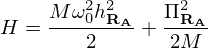

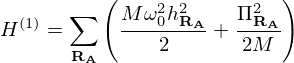

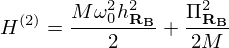

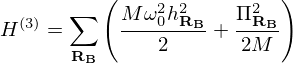

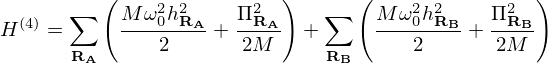

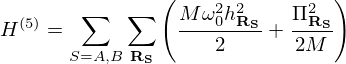

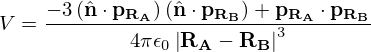

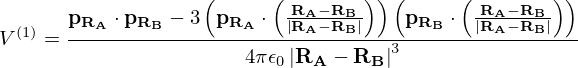

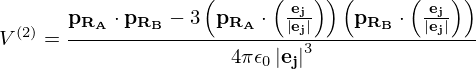

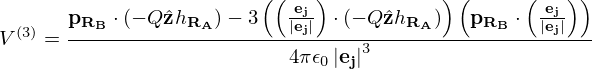

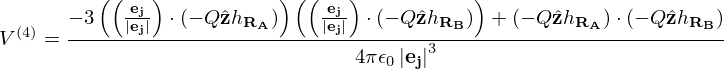

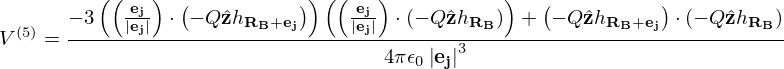

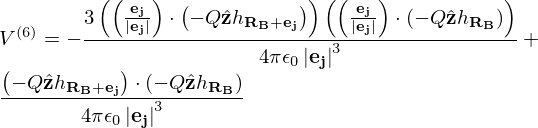

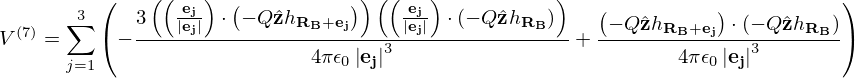

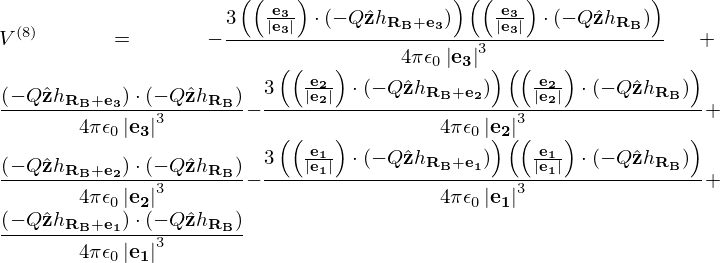

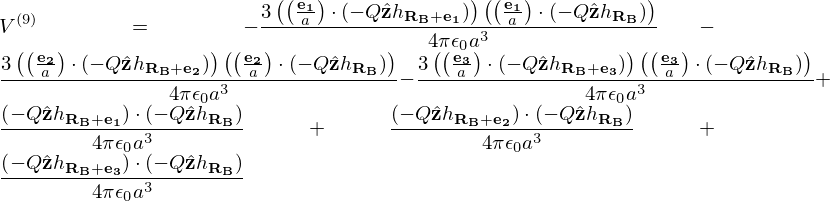

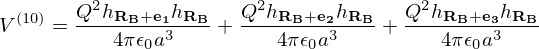

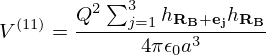

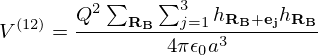

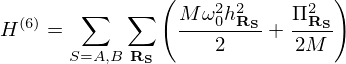

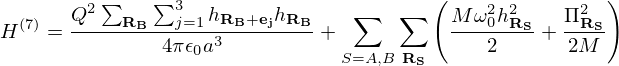

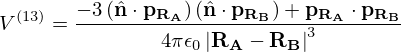

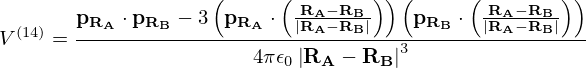

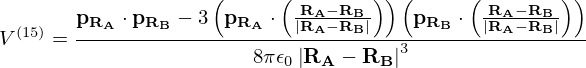

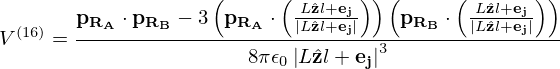

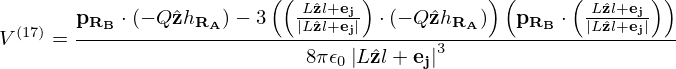

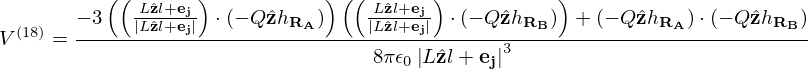

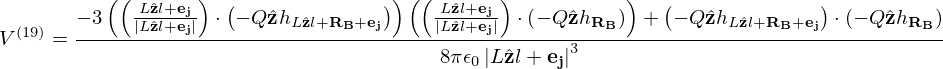

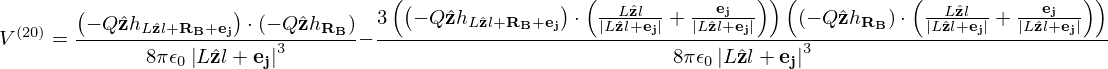

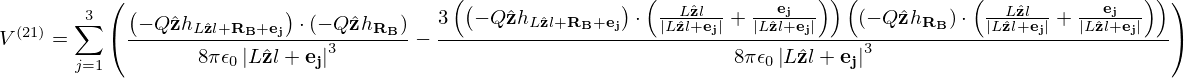

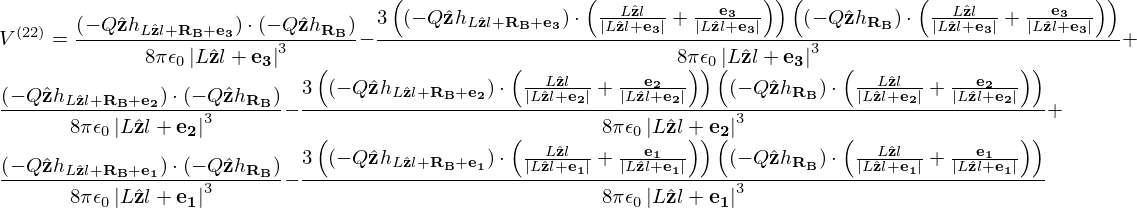

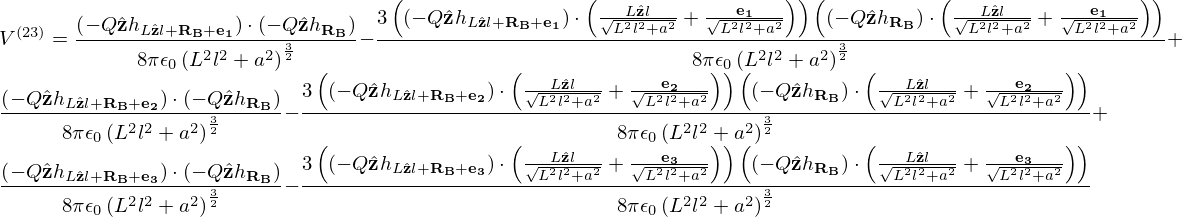

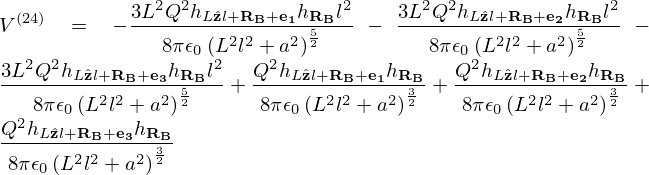

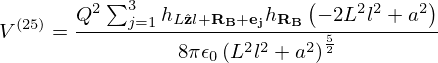

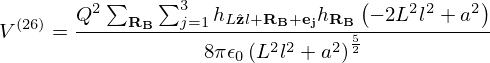

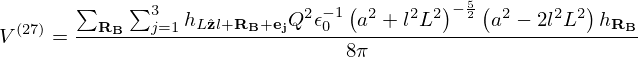

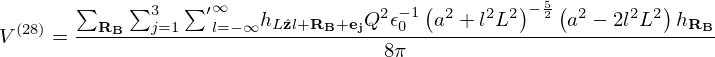

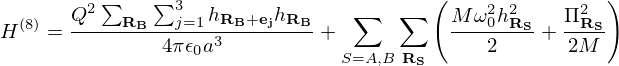

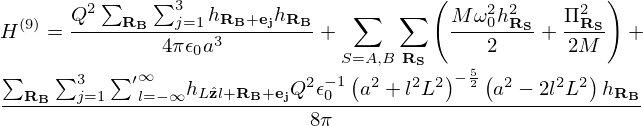

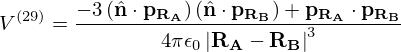

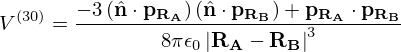

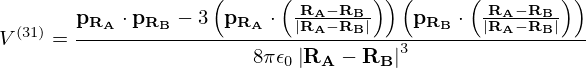

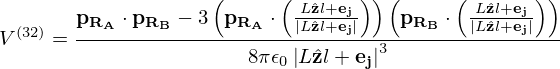

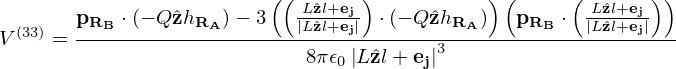

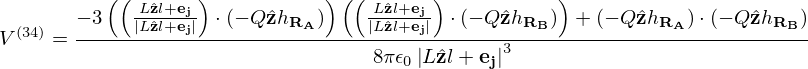

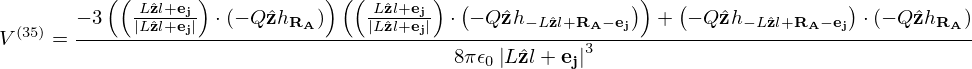

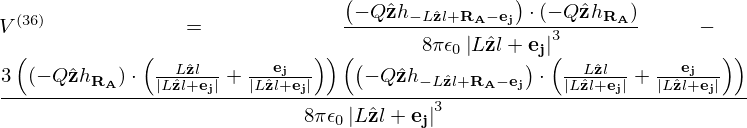

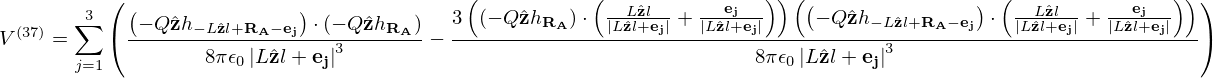

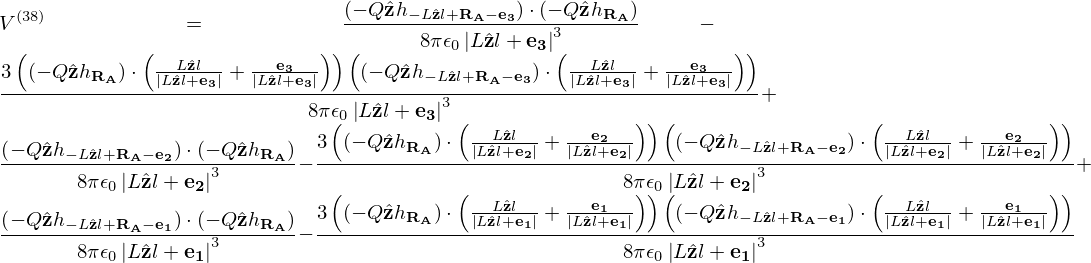

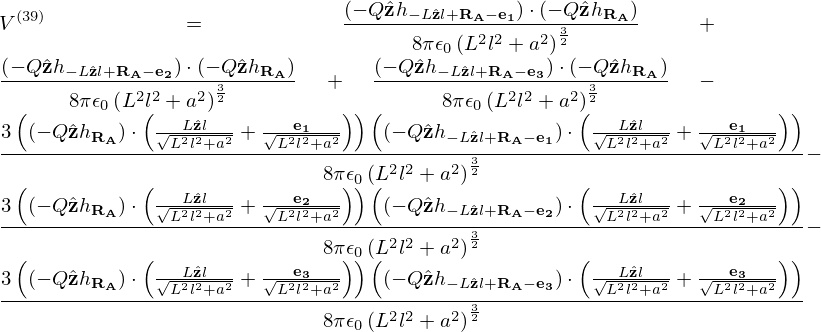

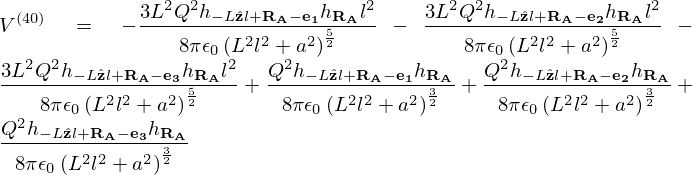

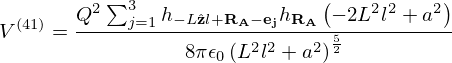

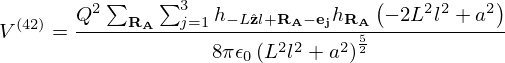

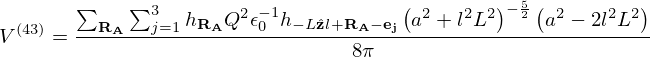

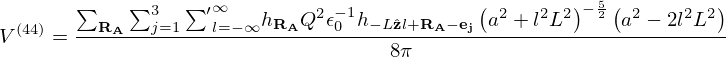

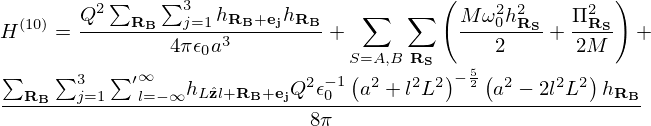

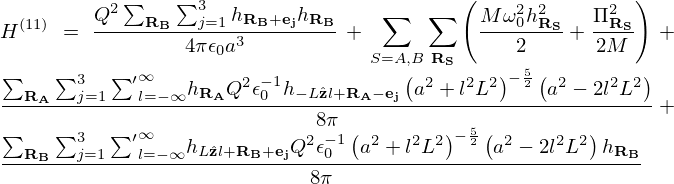

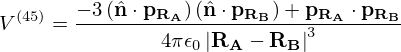

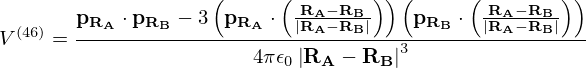

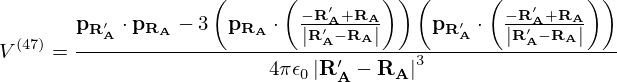

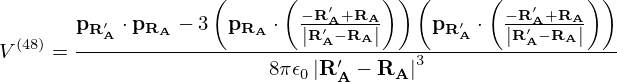

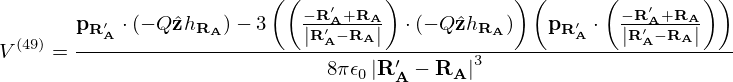

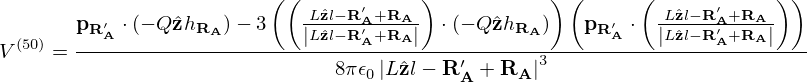

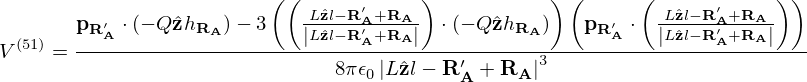

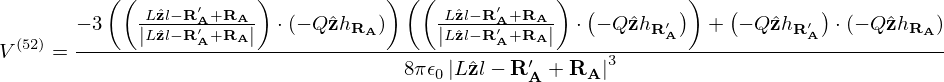

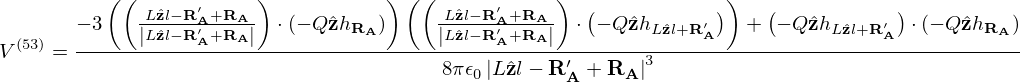

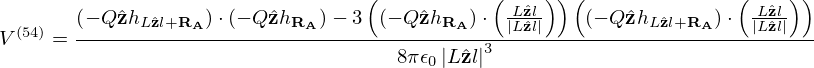

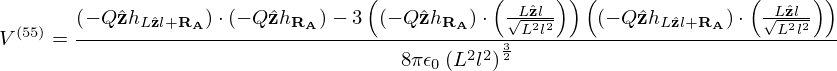

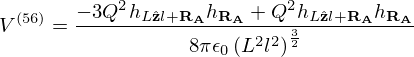

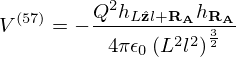

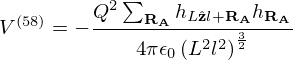

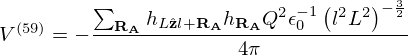

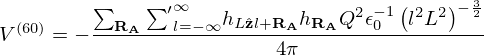

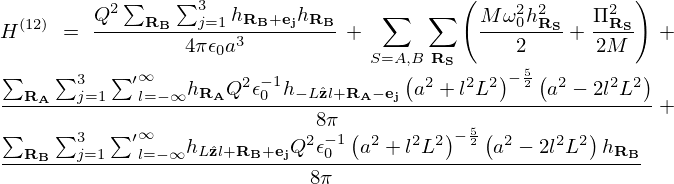

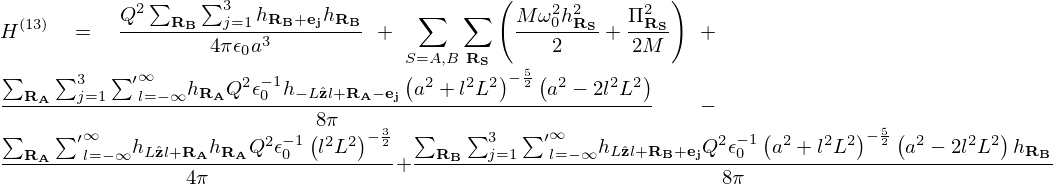

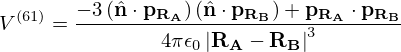

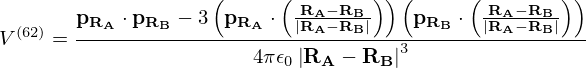

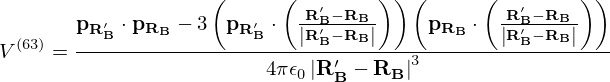

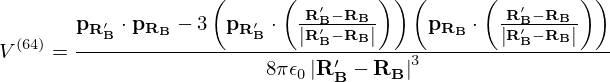

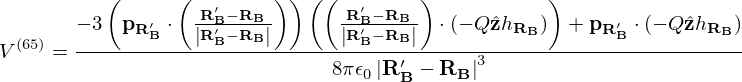

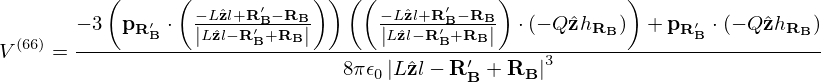

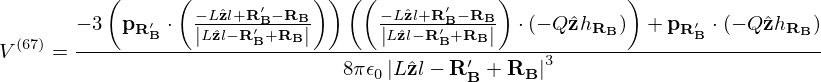

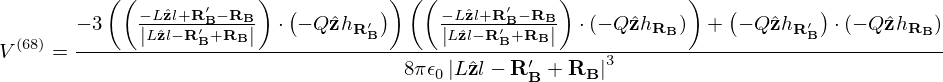

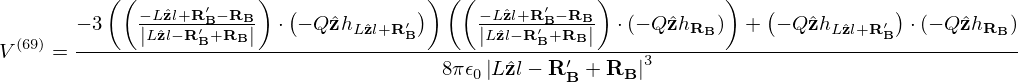

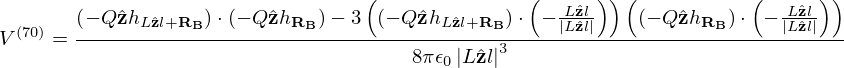

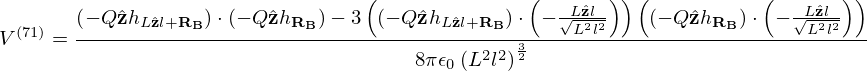

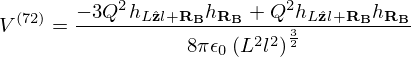

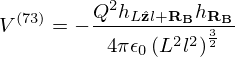

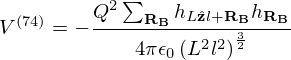

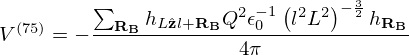

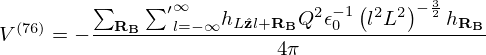

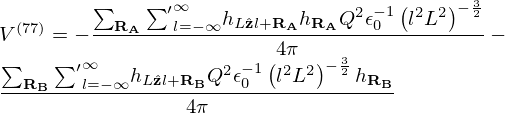

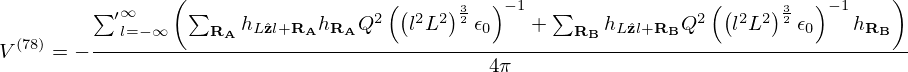

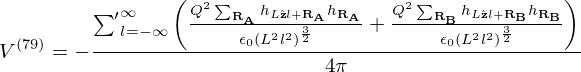

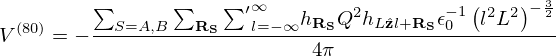

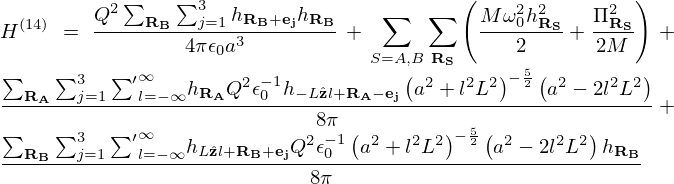

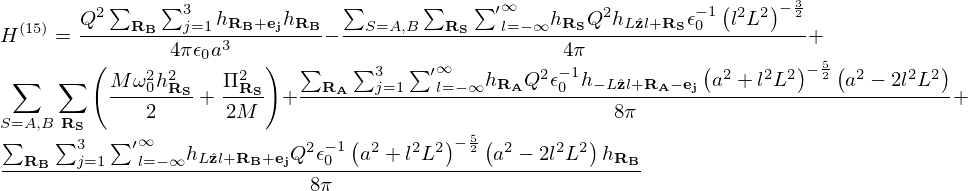

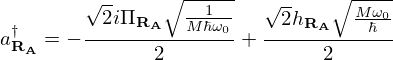

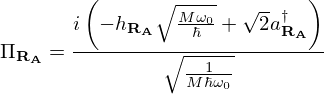

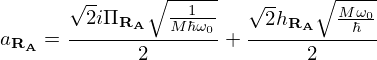

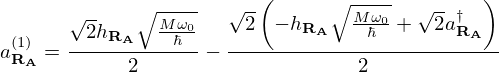

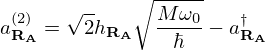

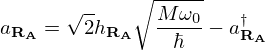

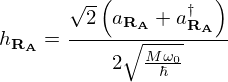

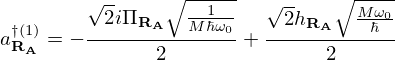

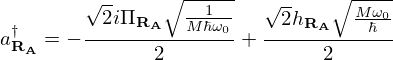

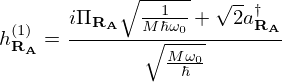

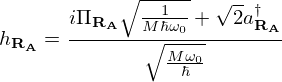

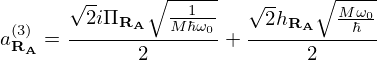

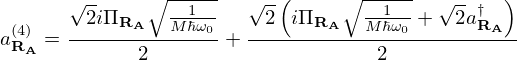

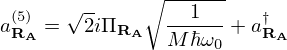

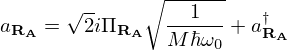

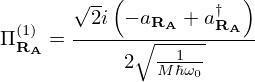

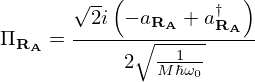

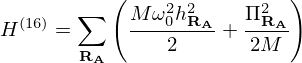

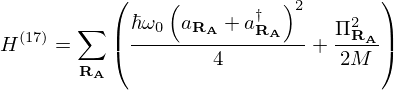

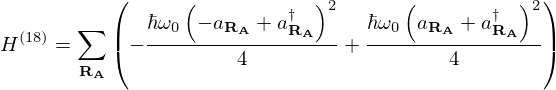

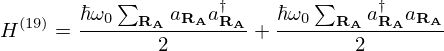

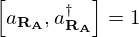

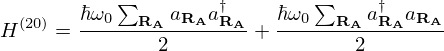

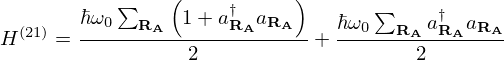

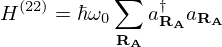

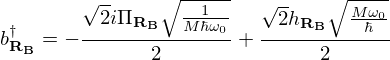

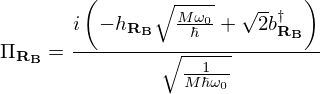

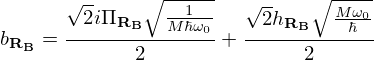

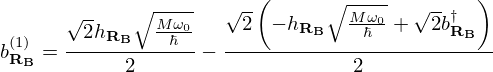

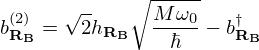

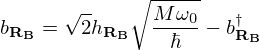

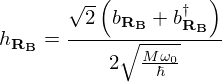

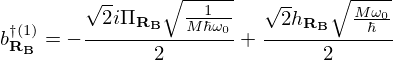

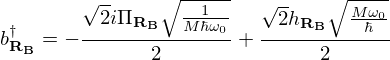

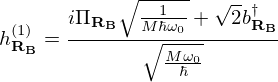

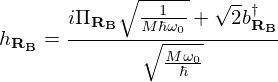

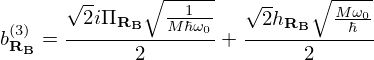

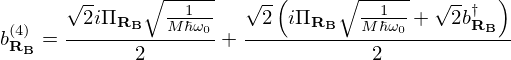

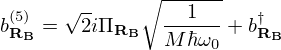

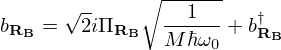

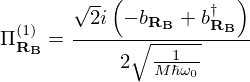

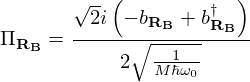

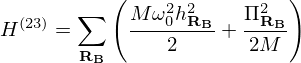

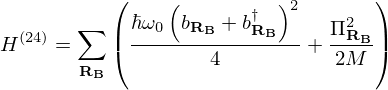

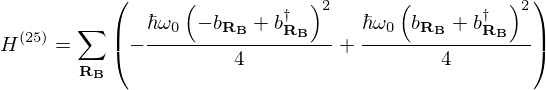

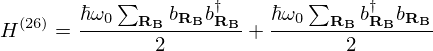

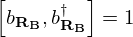

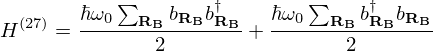

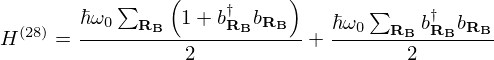

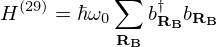

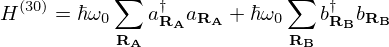

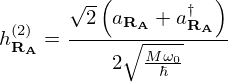

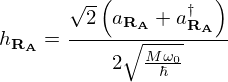

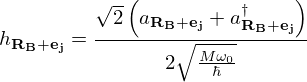

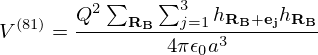

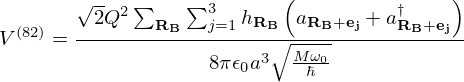

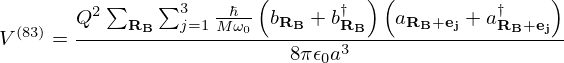

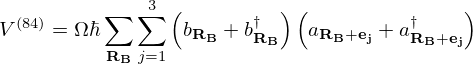

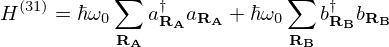

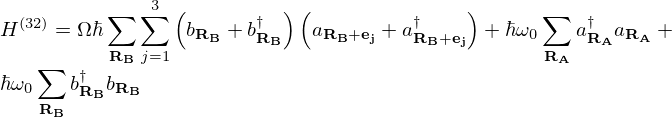

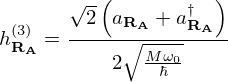

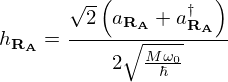

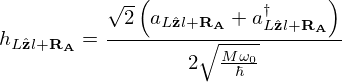

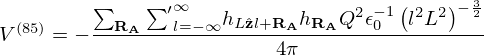

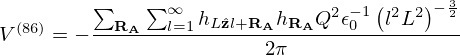

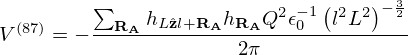

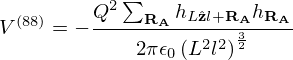

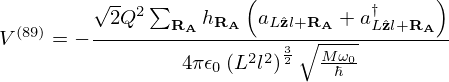

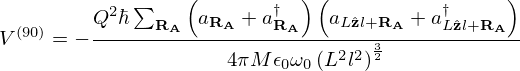

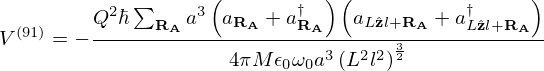

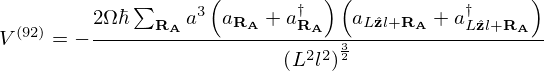

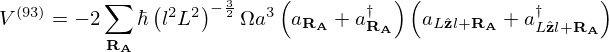

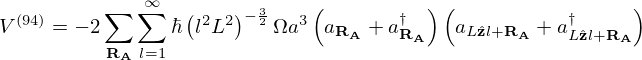

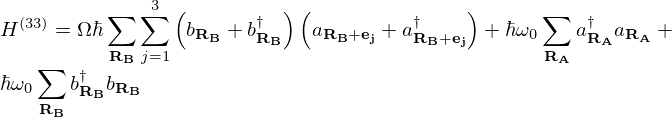

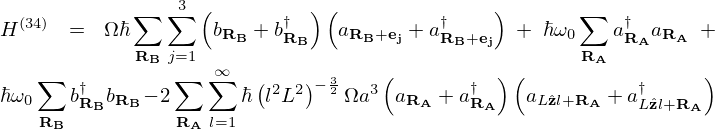

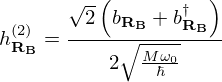

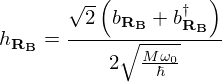

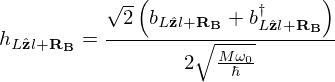

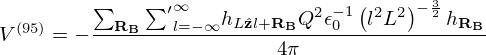

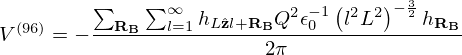

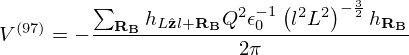

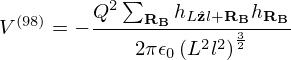

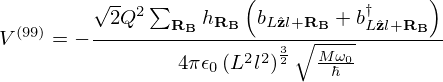

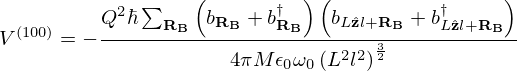

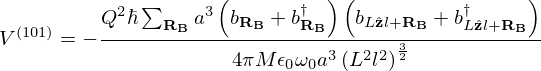

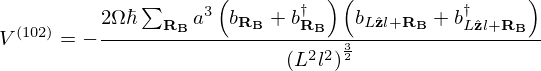

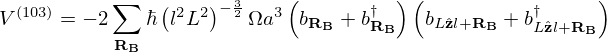

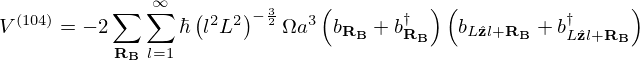

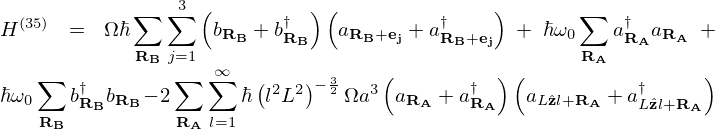

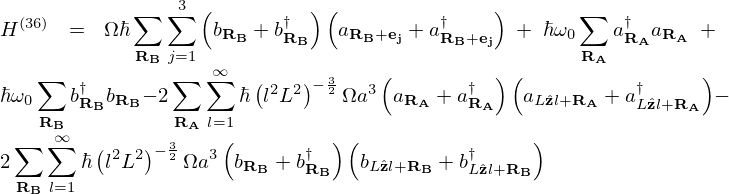

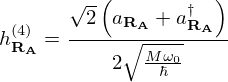

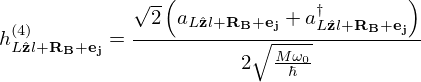

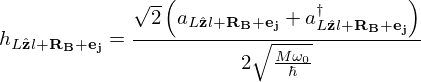

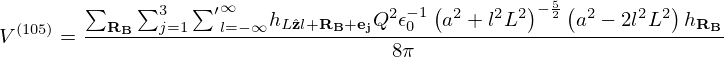

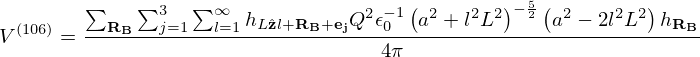

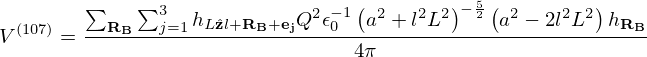

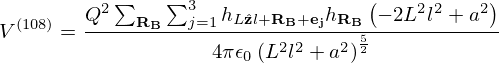

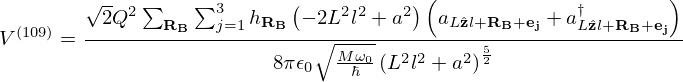

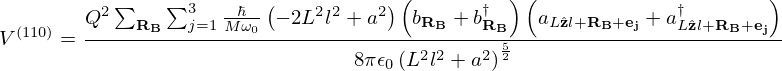

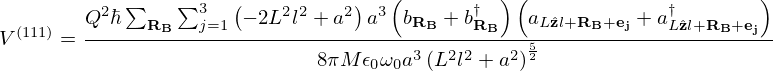

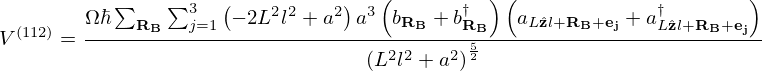

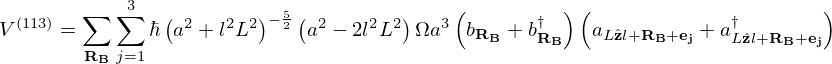

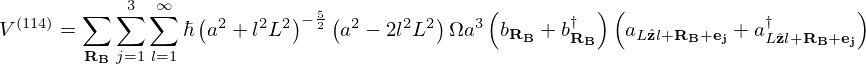

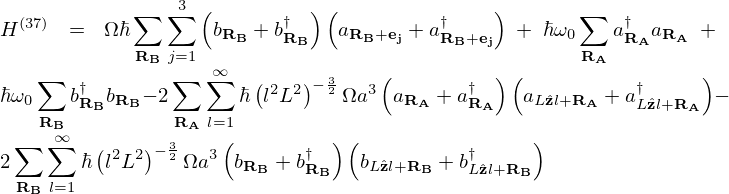

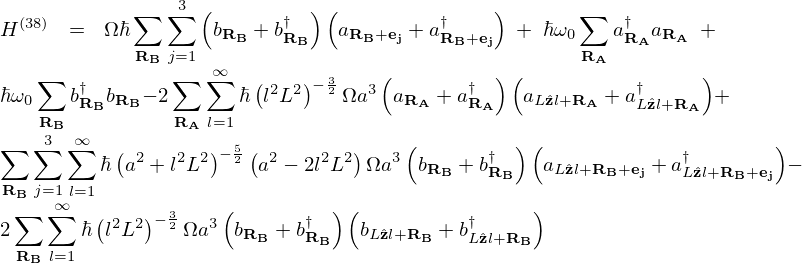

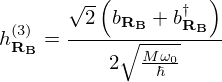

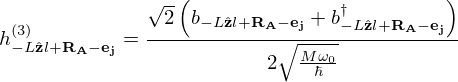

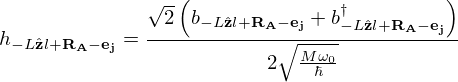

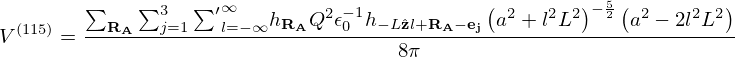

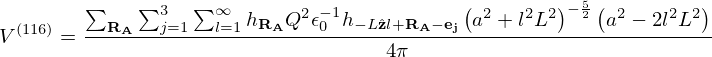

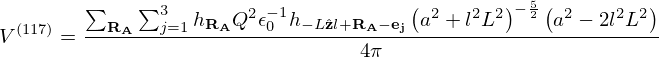

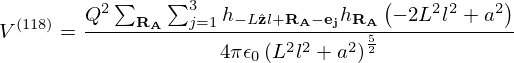

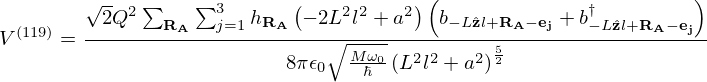

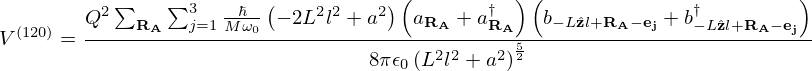

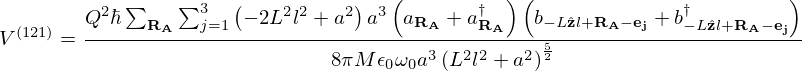

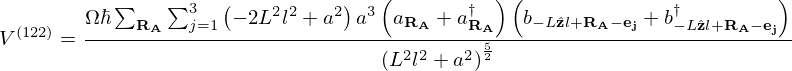

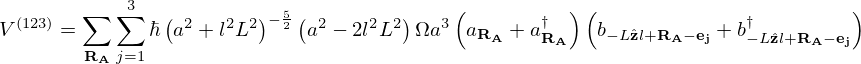

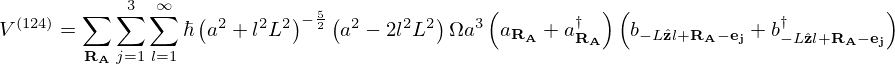

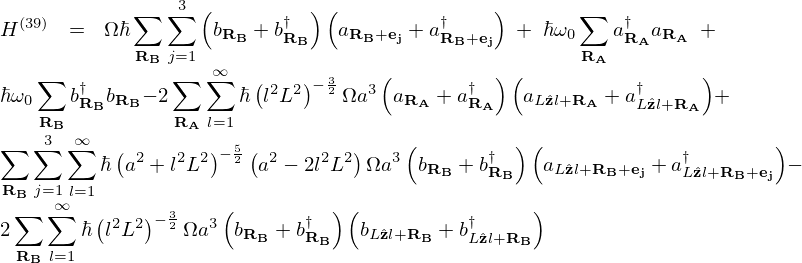

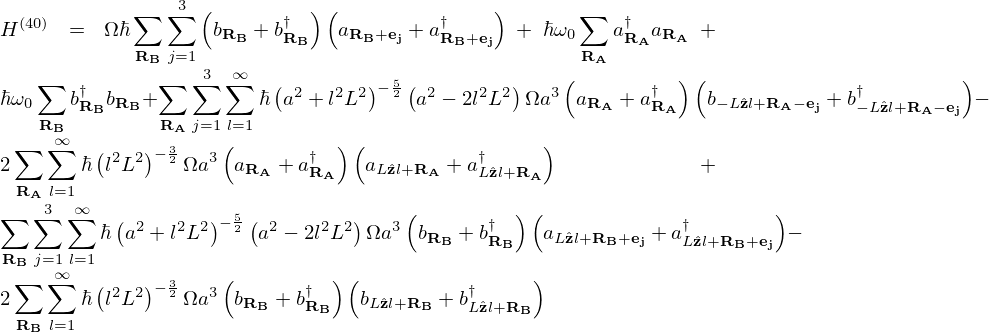

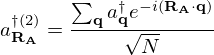

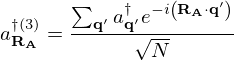

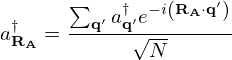

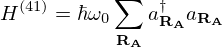

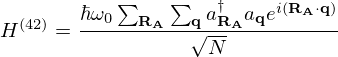

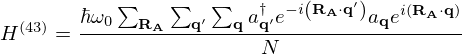

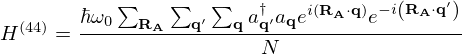

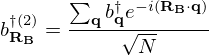

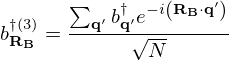

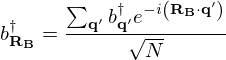

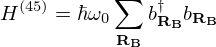

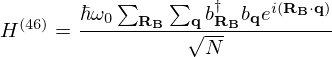

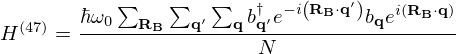

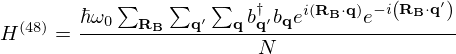

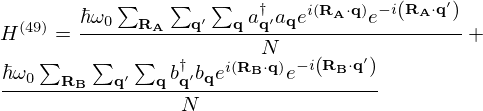

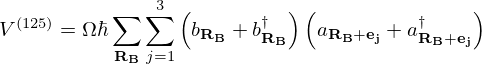

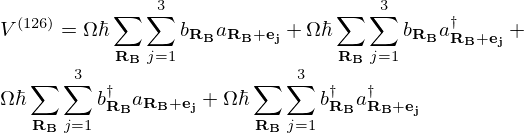

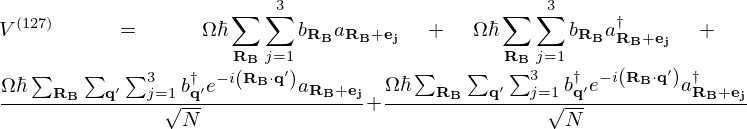

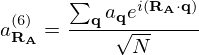

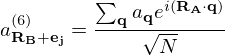

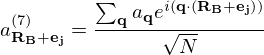

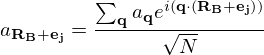

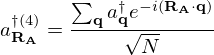

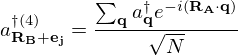

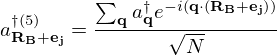

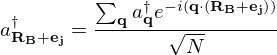

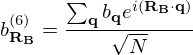

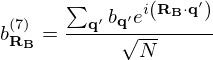

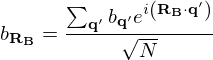

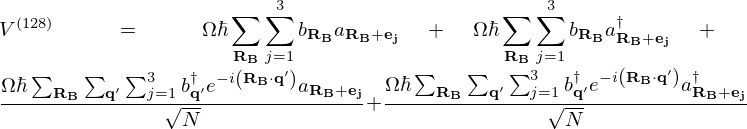

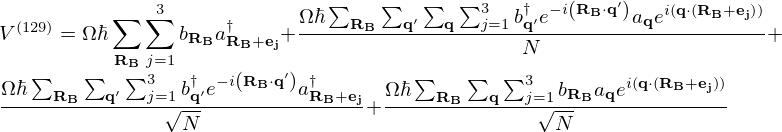

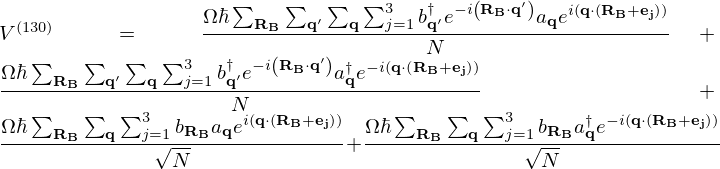

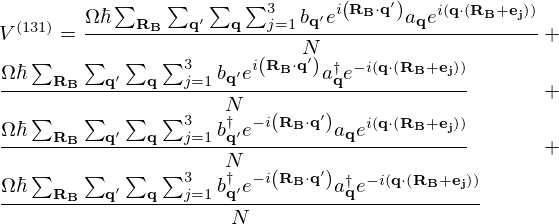

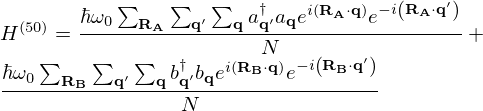

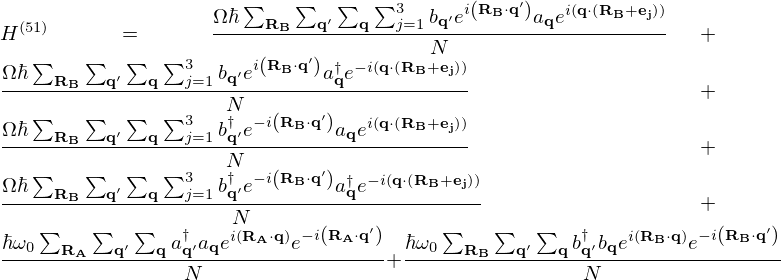

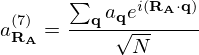

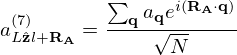

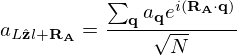

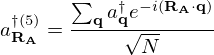

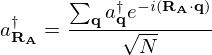

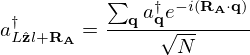

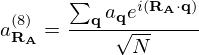

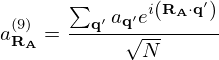

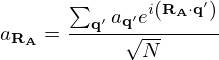

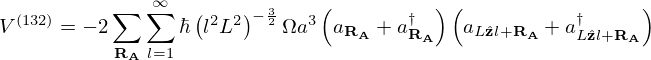

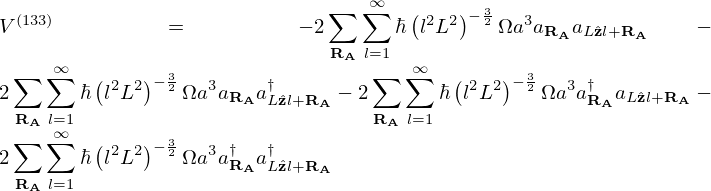

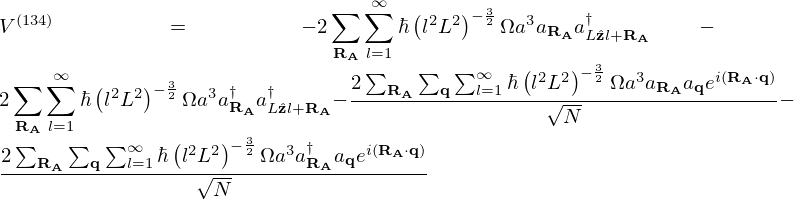

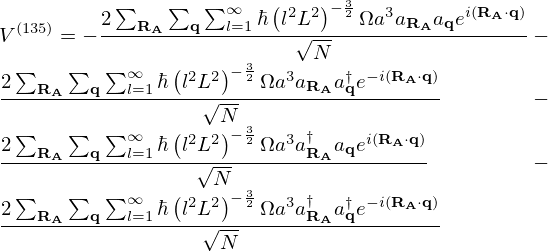

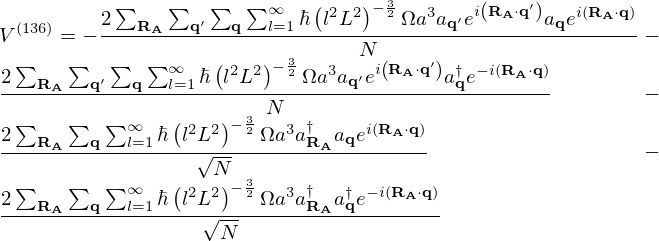

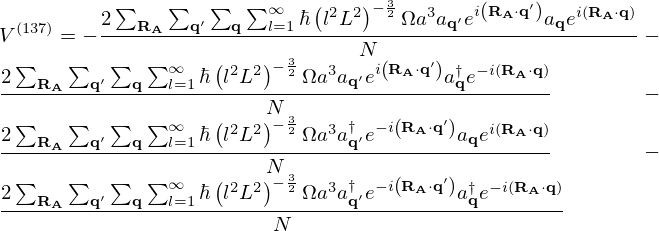

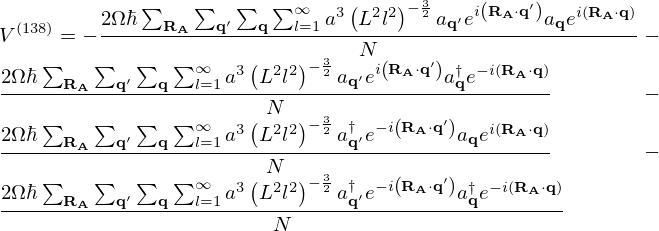

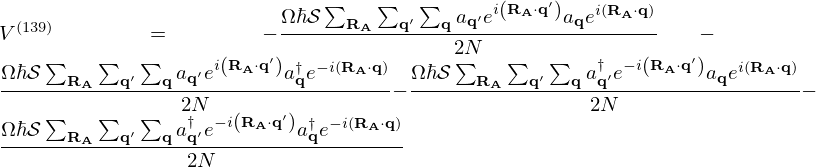

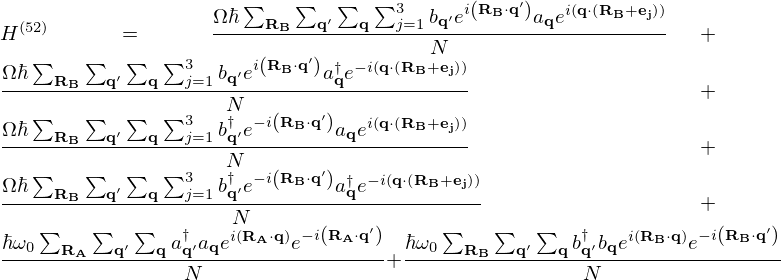

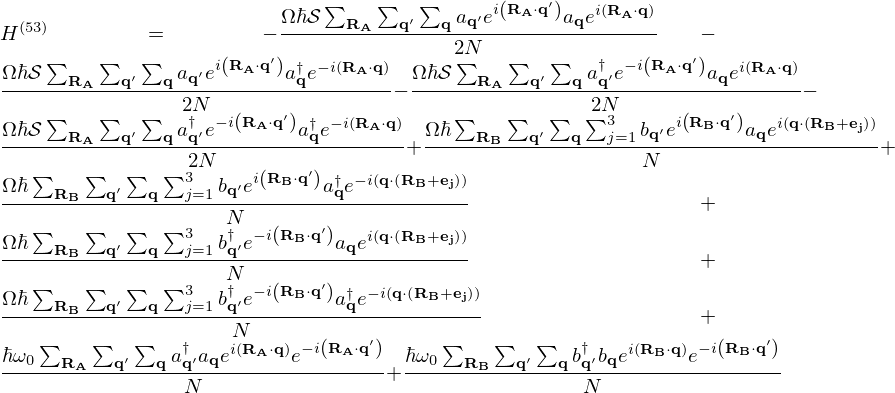

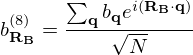

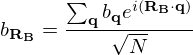

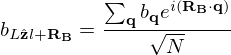

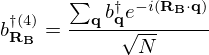

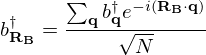

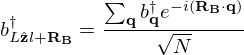

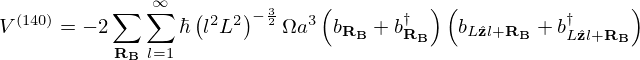

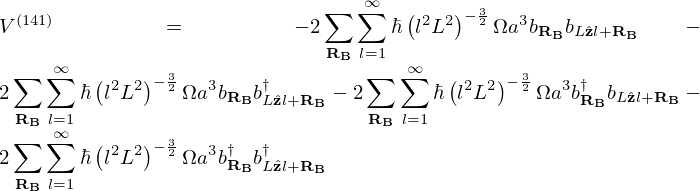

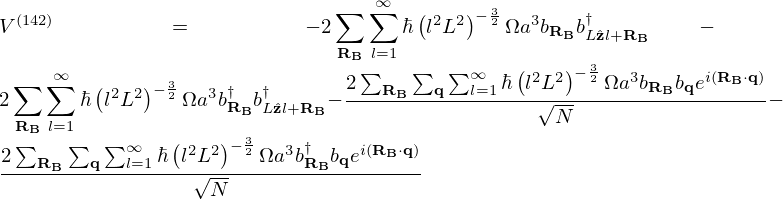

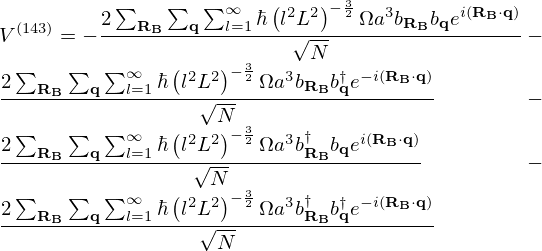

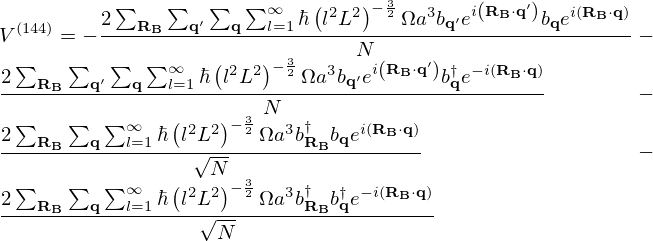

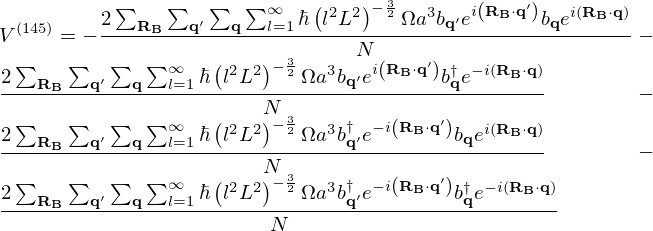

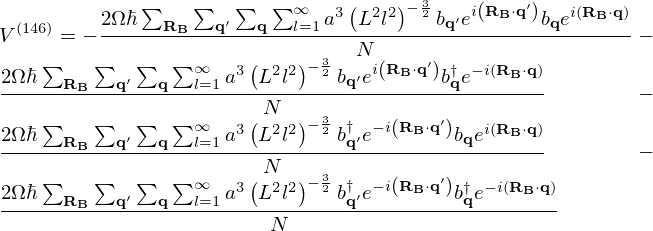

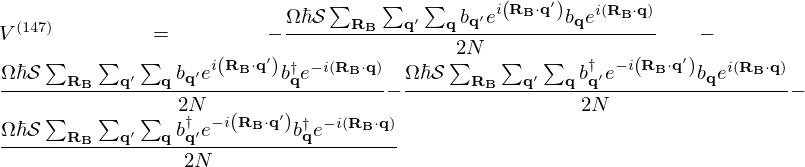

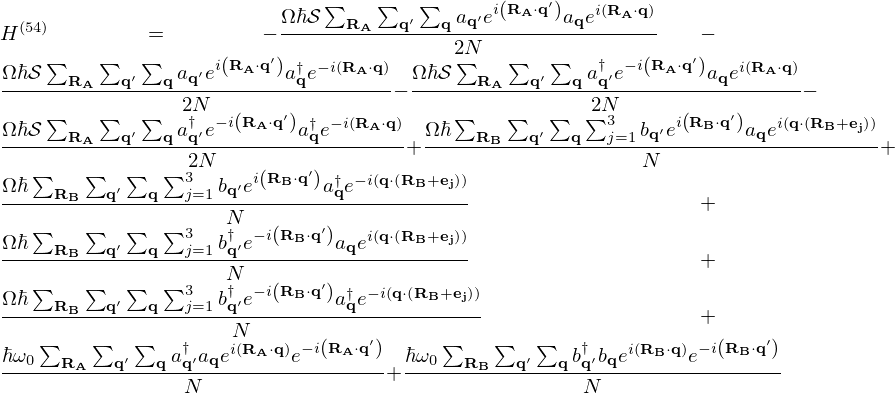

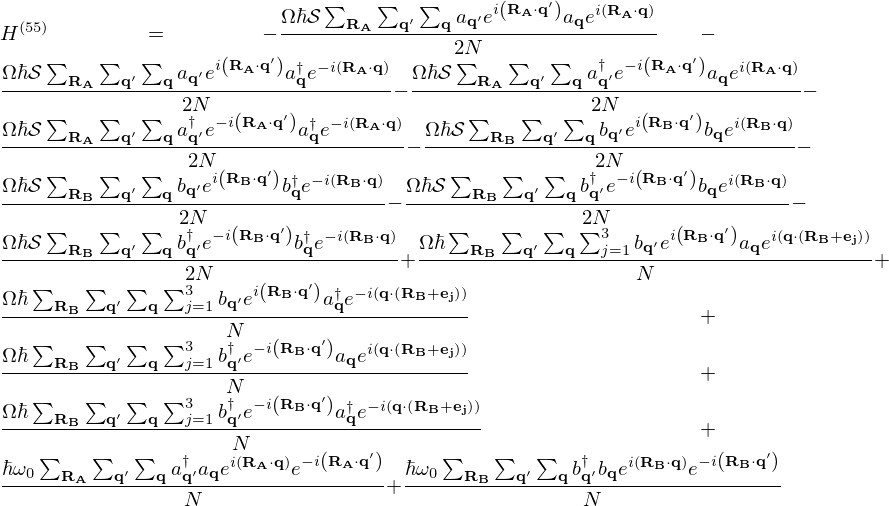

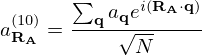

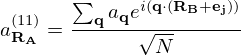

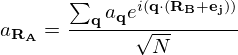

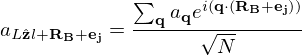

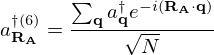

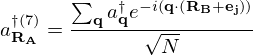

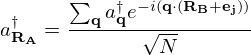

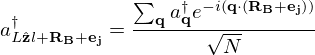

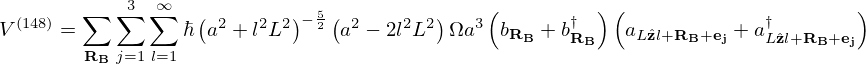

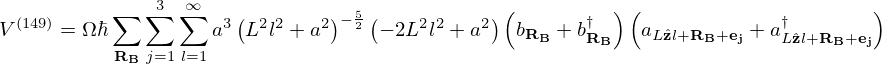

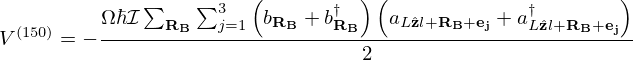

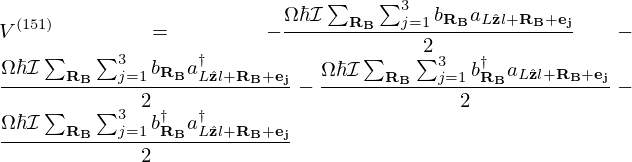

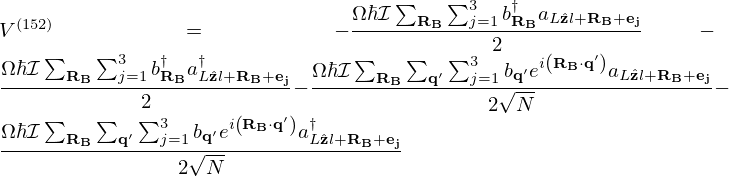

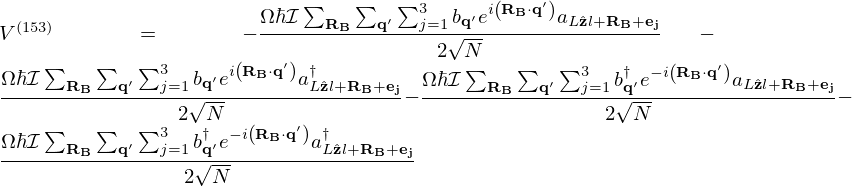

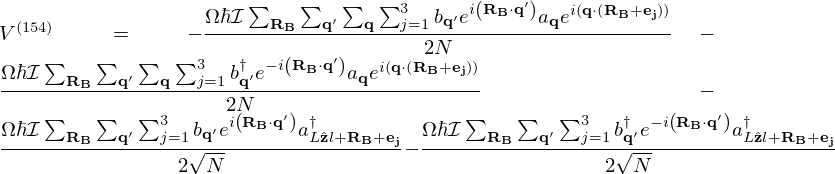

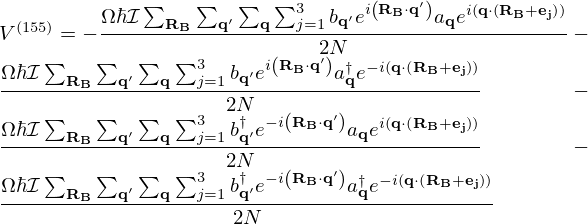

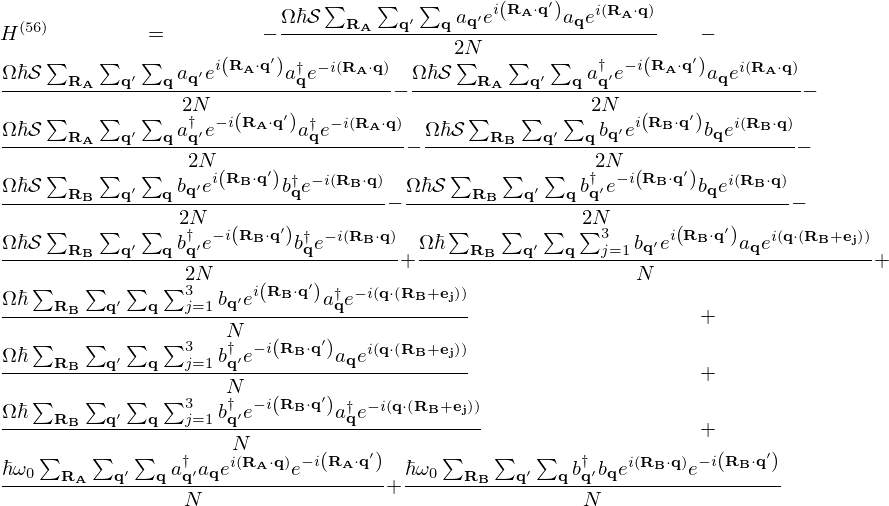

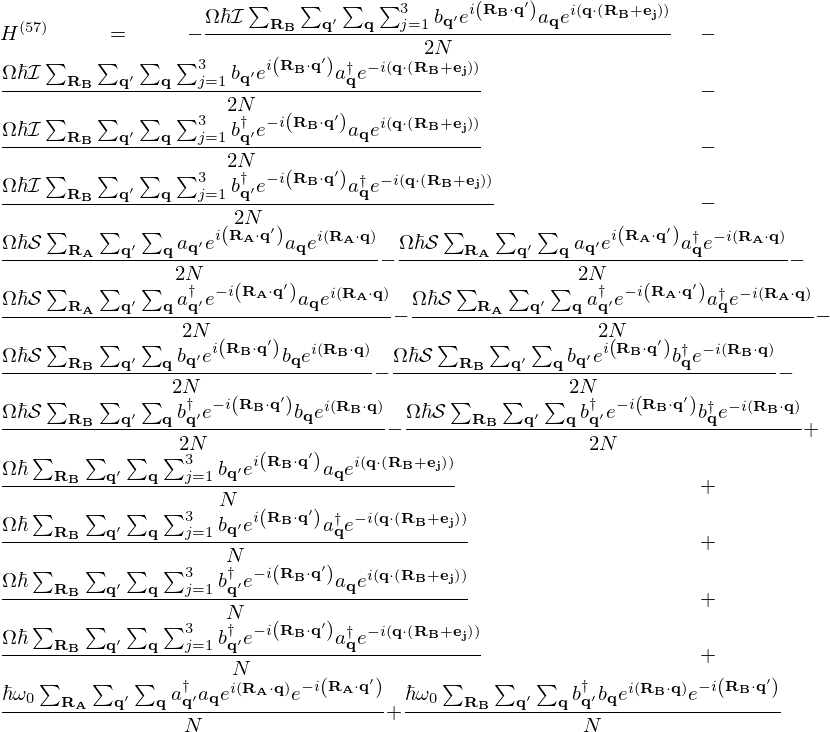

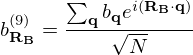

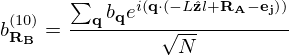

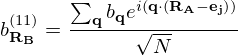

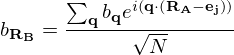

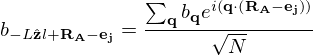

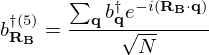

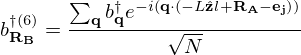

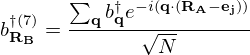

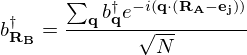

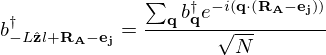

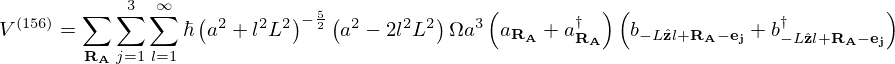

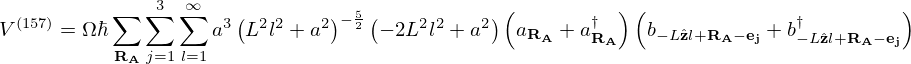

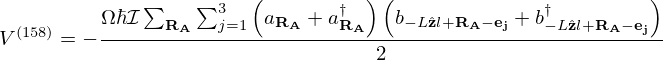

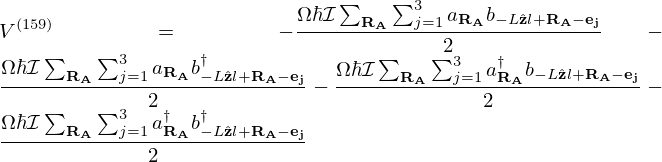

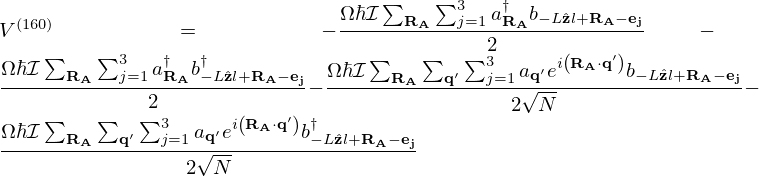

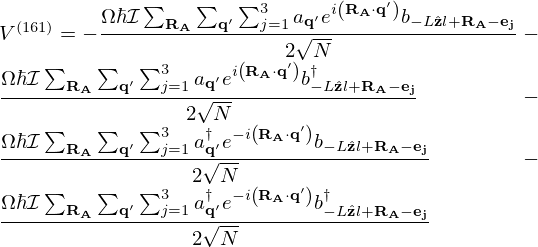

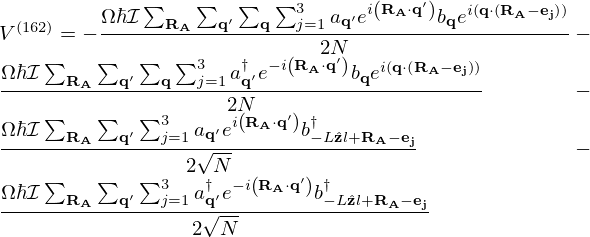

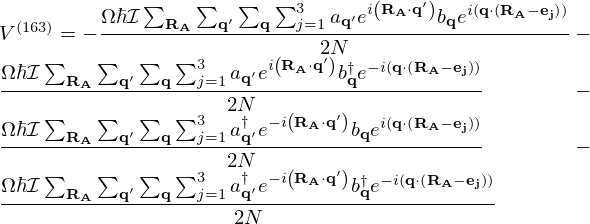

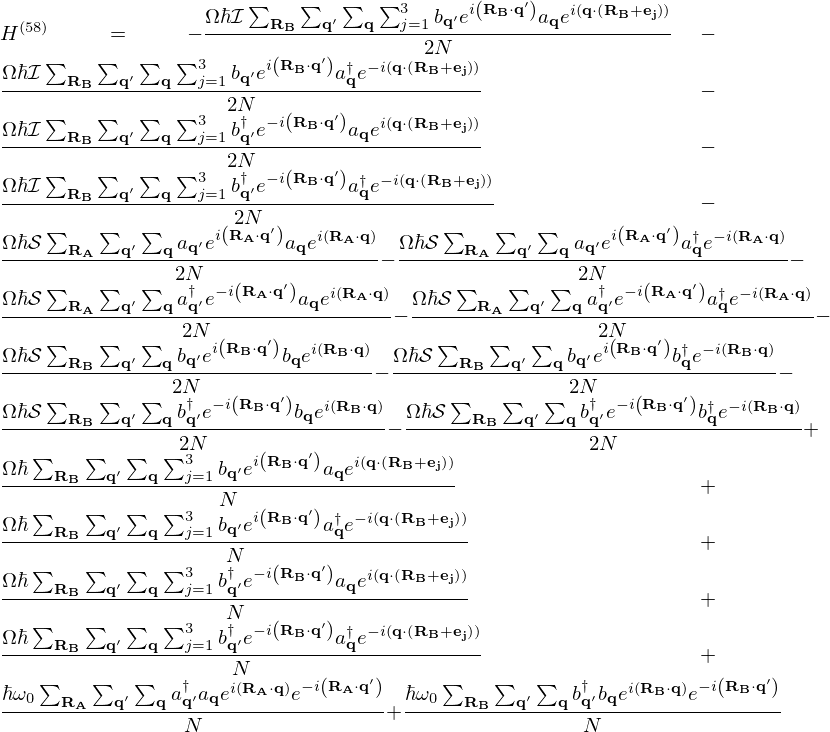

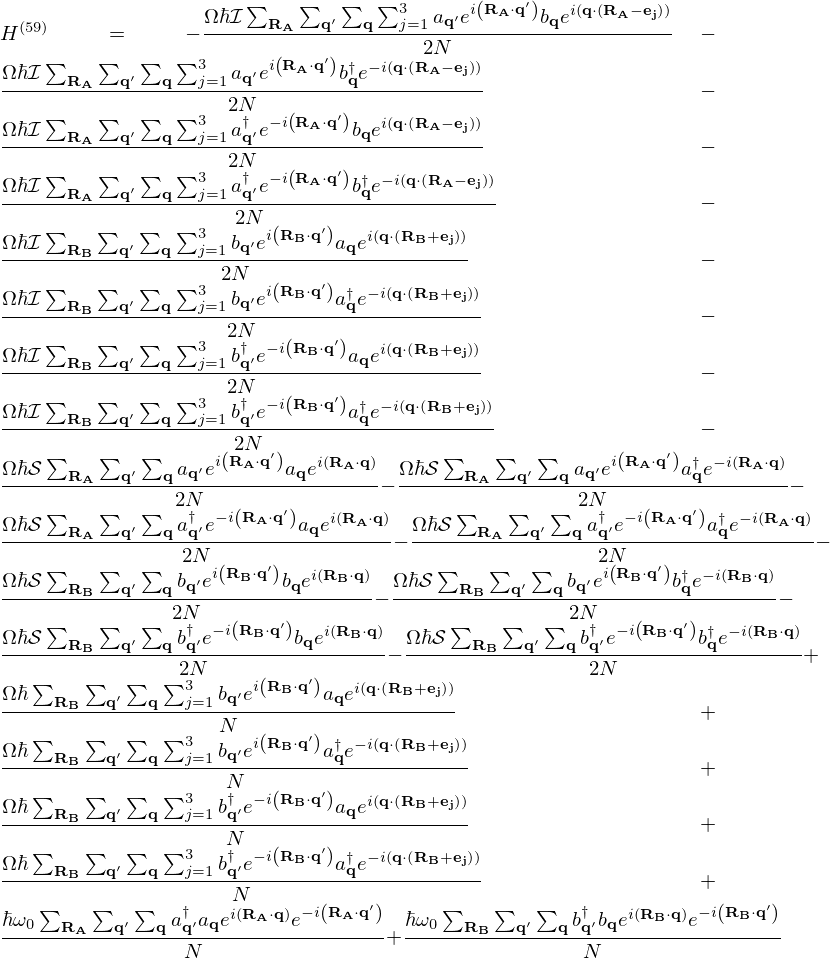

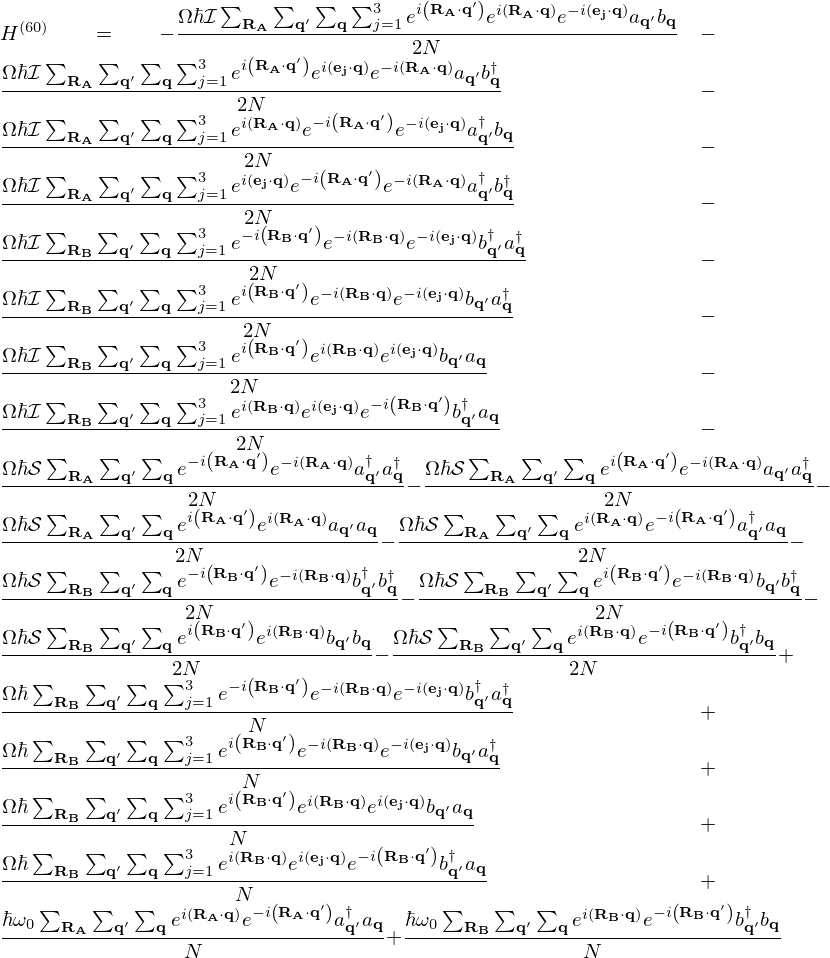

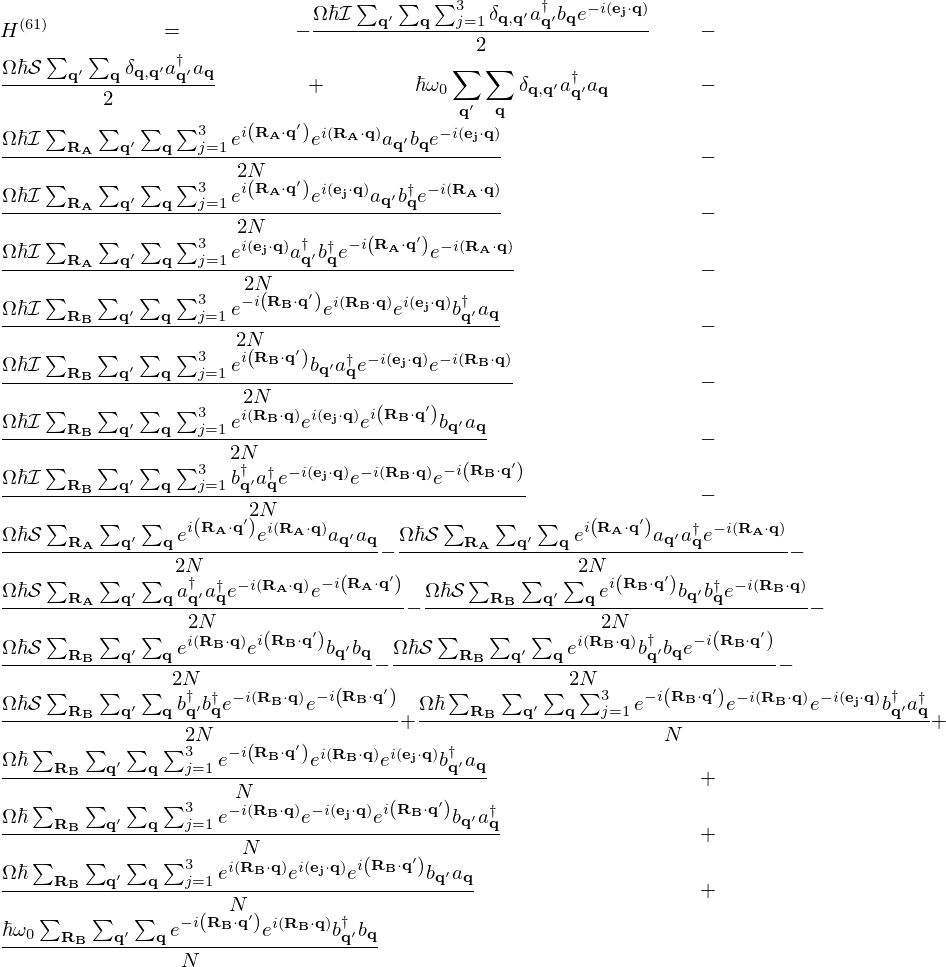

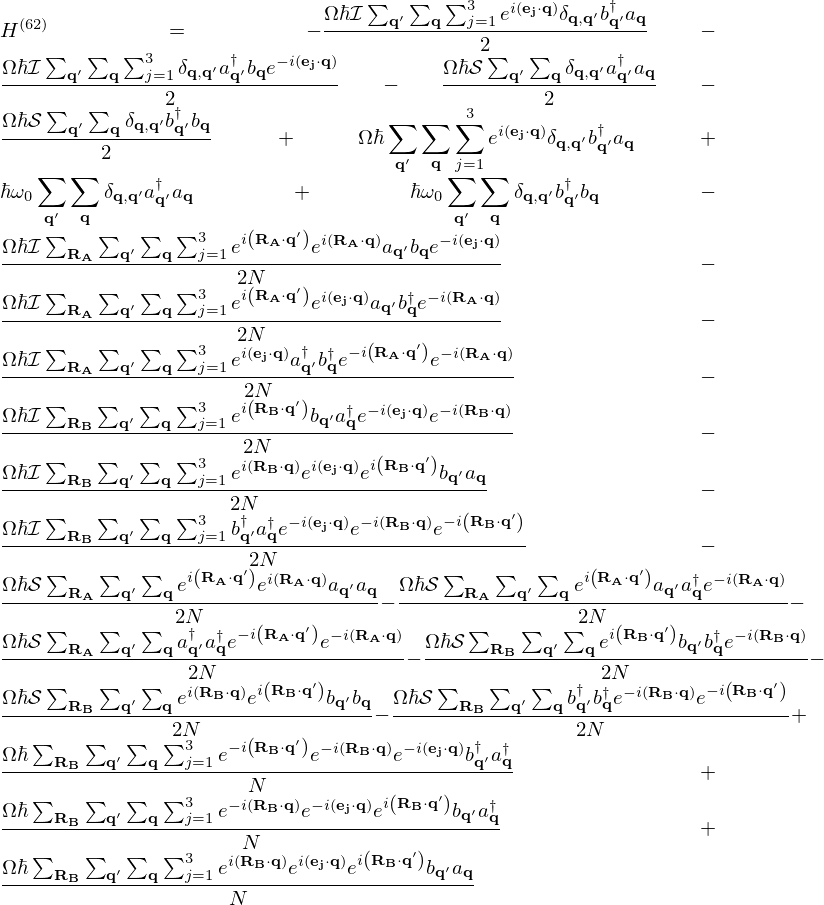

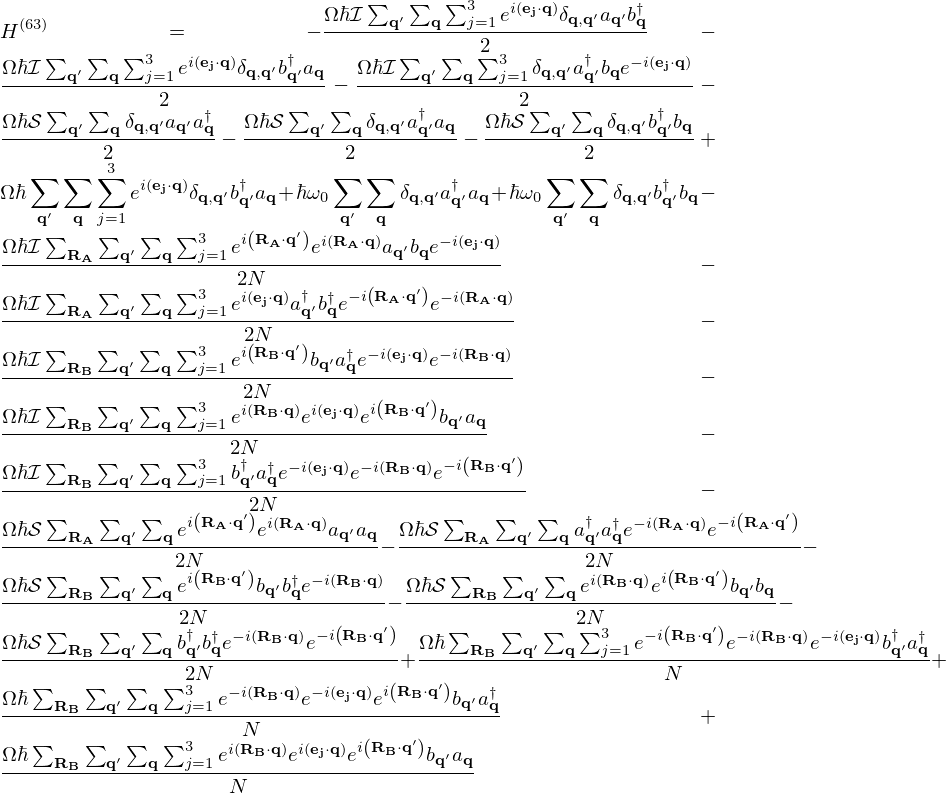

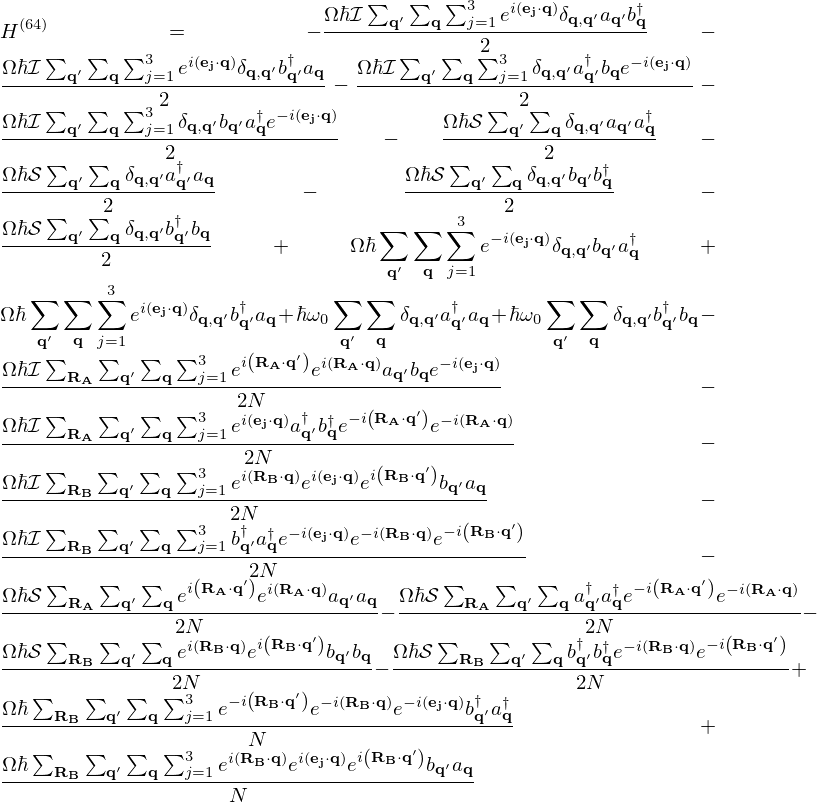

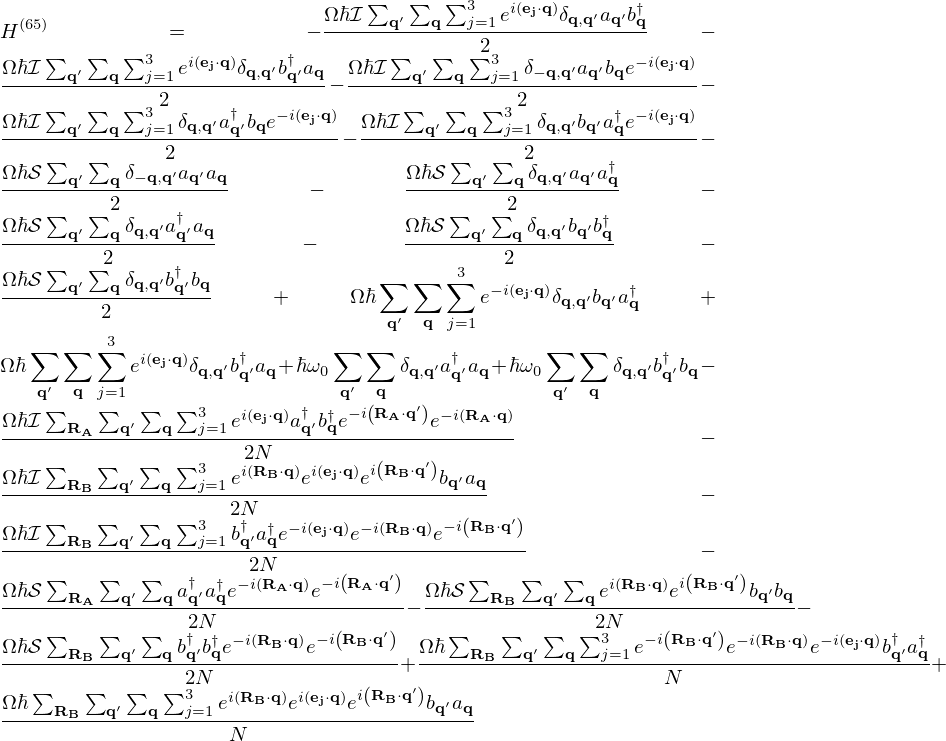

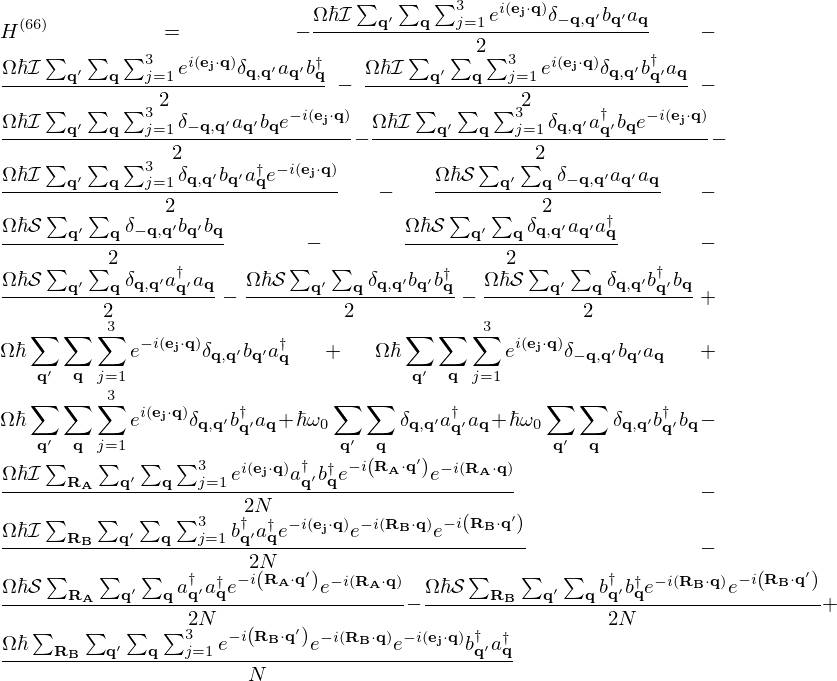

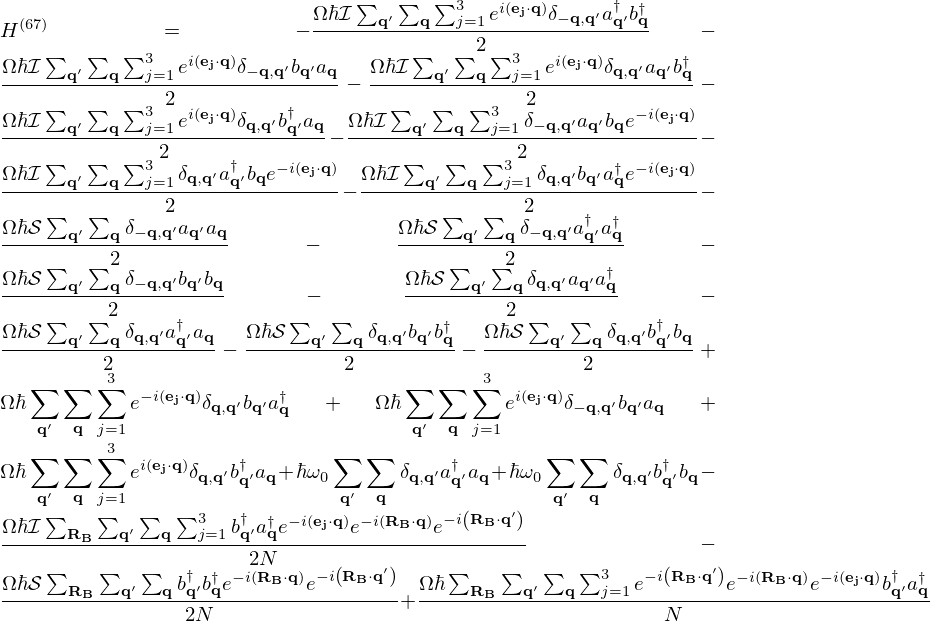

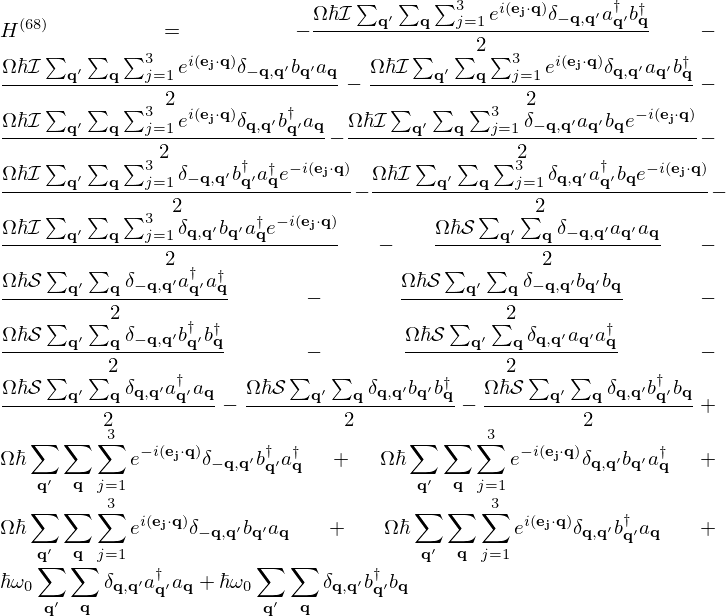

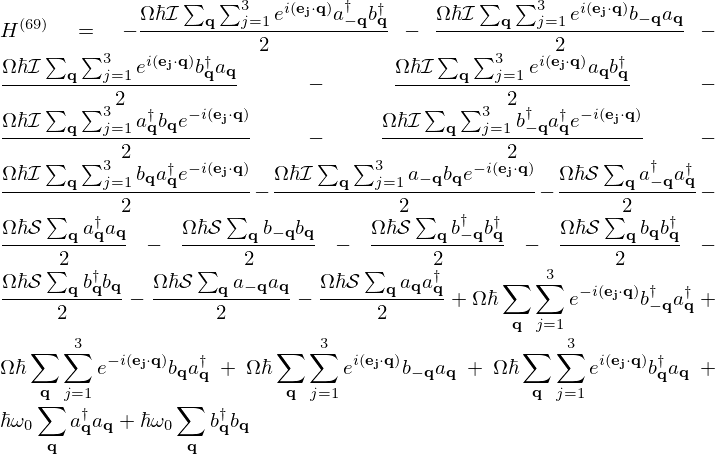

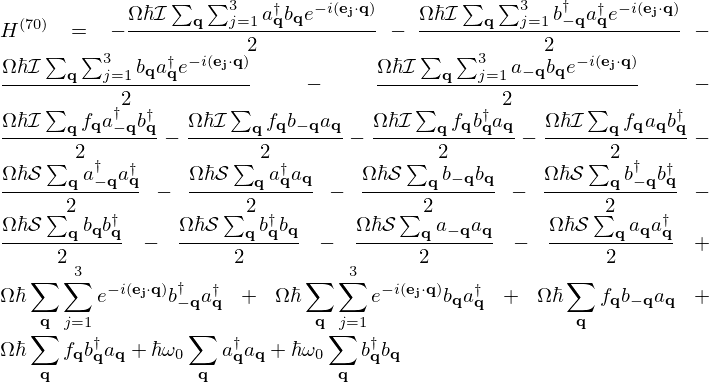

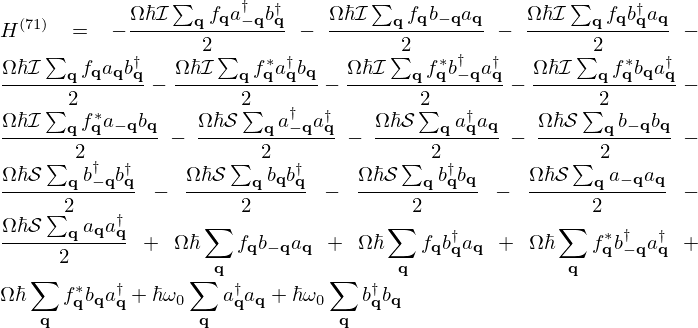

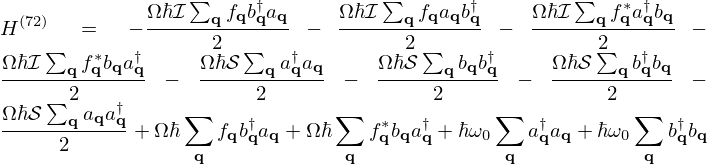

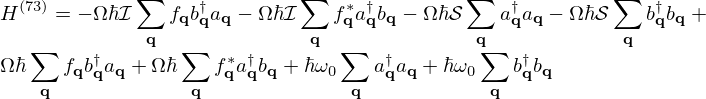

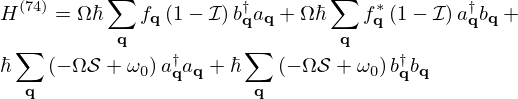

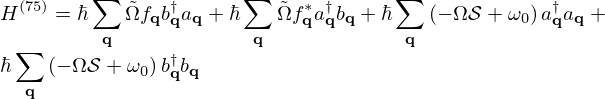

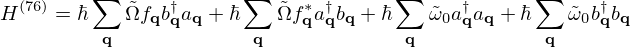

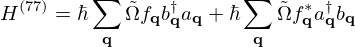

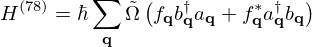

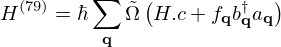

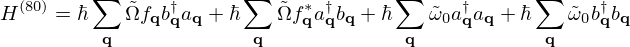

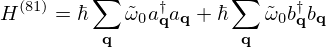

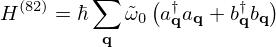

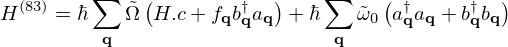

In [8]:
for state in new_state_history:
    display(state)

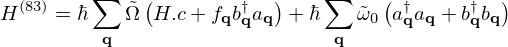

In [7]:
new_state_history[-1]